# Multi-Agent Bidding





In this notebook, we have implemented and tested different bots for the First and Second bidding auctions.



*Authors:*

*-Nikolas Petrou 3195*

*-Loukas Chatzivasili 3187*

*-Grigoris Barbas 3108*

*-Konstantinos Loizou 3184*

*-Sotiris Ftiakas 3076*


## Importing necessary Libraries

In [ ]:
from abc import ABC
import random
import math
import operator

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import numpy as np

import random
import hashlib

# Bots

Below are the Classes implemented for the different bots 


## Class Bot 

This class is an Abstract Class that is used in order to define the bots that use different strategies with simillar methods and shared variables.

For this Class and the rest of the Sub-classes, notice that if a specific bot has won the last round, then the parameter `winner` of the method `play_round()` is equal to 0 

In [ ]:
# Default budget for each bot is 1000
# self.rounds are the remaining rounds

# Abstract Bot class
class Bot(ABC):
    # Class Dictionary used for the naming of the bots
    # holds the number of bots implemented for each and every bot type 
    num_of_bot_dict = {}


    def __init__(self, budget=1000):

        # Initialize name of the bot
        # If existing key overwrite or if new key add to dictionary
        number_of_type = Bot.num_of_bot_dict.get(type(self).__name__)
        if number_of_type is None:
            number_of_type = 1
        else:
            number_of_type += 1
        Bot.num_of_bot_dict[type(self).__name__] = number_of_type
        self.__name__ = (type(self).__name__) + " " + str(number_of_type)

        # Initialize budget
        self.dollar = budget

    def clear_dict():
        Bot.num_of_bot_dict = {}

    def play_round(self, winner, win_amount, round_payment):

        if winner == 0: 
            self.dollar -= win_amount
            
        # FOR NEGATIVE round_payment VALUES:
        # If his budget is less than the round payment, make his budget equal 0. 
        # Else, subtract the round payment from its budget.
        if (self.dollar + round_payment) > 0:
            self.dollar += round_payment
        else:
            self.dollar = 0

    def set_auction_rounds(num_of_rounds):
        Bot.auction_rounds = num_of_rounds

    def get_dollars(self):
        return self.dollar

    def __str__(self):
        return self.__name__ 

## Class Random_bot 

In [ ]:
class Random_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)
        random.seed(40)

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        # Using a random seed in order to use a pseudo-random generator and produce same results on each run
        return random.randrange(self.dollar+1)

## Class Average_bot 

In [ ]:
class Average_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds + 1

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1
        return self.dollar / self.rounds

## Class Escalating_bot 

In [ ]:
# Escalating Quickly
# Bids increasing fractions of its money each round
class Escalating_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)
        self.rounds_passed = 0
    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds_passed += 1
        return self.dollar * self.rounds_passed // Bot.auction_rounds


## Class Distributer_bot 

In [ ]:
# Distributes it's money equally on each round.
# E.g. When it's current budget is $500, it will be be trying to bid 500/(no of remaining rounds) 
class Distributer_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds + 1
    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1
        if (((self.dollar // 2) -1) <= 0) or  ((((self.rounds - 1) * round_payment + self.dollar) // self.rounds ) <=0):
            return 0
        if (self.rounds == Bot.auction_rounds): # first round
            #return (self.dollar - 1) # all in -1
            return (self.dollar // 2) -1
        return ((self.rounds - 1) * round_payment + self.dollar) // self.rounds 
        #return self.dollar // self.rounds

## Class Minus_one_bot 

In [ ]:
# Bids every round all his dollars that has this round -1 example if it has 500 he will bid 499
class Minus_one_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)

        if self.dollar > 0:
          return self.dollar - 1
        else:
          return 0

## Class Half_in_bot 

In [ ]:
# This bot always bids half of what it has left, except in the final round where it will go all in.
class Half_in_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds + 1

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1
        if self.rounds == 1: # last round
          return self.dollar
        # Else: Bid half what it has left:
        return self.dollar / 2


## Class One_upper_bot

In [ ]:
# Bot that bids 1$ higher than the previous winning bid, or goes all-in during the last round.
# Random bots, or generally high bidding bots, make it spend its budget in the first rounds.
# Always loses first round, as it bids 0$. We can change that (or not)
class One_upper_bot(Bot):
     def __init__(self, name="", budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds+1
        
     def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1
        
        if(self.rounds == 1):
            return self.dollar
        
        bid = win_amount + 1
        
        if(self.dollar>=bid):
            return bid
        else:
            return self.dollar

## Class Two_thirds_bot

In [ ]:
# Bot that skips first 1/3 rounds and bids on 2/3 last rounds. 
# His bidding strategy on the last rounds is the same as the Average_bot
# Focuses on winning last rounds
# Other bots that bid high on last rounds might make it lose. 
class Two_thirds_bot(Bot):
    def __init__(self, name="", budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds+1
        self.total_rounds = Bot.auction_rounds
        
    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1 
        if(self.rounds <= math.ceil(self.total_rounds*2/3)):
            bid = self.dollar / self.rounds
            return bid
        else:
            return 0

## Class Fast_AF_Boiii

In [ ]:
# Bot that tries to win as many rounds as possible at the first rounds
# In the first rounds, it gives a bid=budget/total_rounds/5
# If he lost the previous round, it gives previous bid
# If he won the previous round, it gives pervious bid - initial_budget/total_rounds
# May need to fix problems when bid gets too low.

class Fast_AF_Boiii(Bot):
    def __init__(self, name="", budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds+1
        self.rounds_opposite = 0
        self.total_rounds = Bot.auction_rounds
        self.total_budget = budget
        
    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        self.rounds -= 1 
        self.rounds_opposite +=1
        
        if(self.rounds == 1):
            return self.dollar
        
        if(winner==0 or winner==-1):
            bid = self.total_budget/(self.total_rounds/5)-self.rounds_opposite*(self.total_budget/self.total_rounds)
            if (bid>=self.dollar):
                return self.dollar
            elif (bid<=0):
              return 0
            else:
                return bid
        else:
            self.rounds_opposite -= 1
            bid = self.total_budget/(self.total_rounds/5)-self.rounds_opposite*(self.total_budget/self.total_rounds)
            if (bid>=self.dollar):
                return self.dollar
            elif (bid<=0):
                return 0
            else:
                return bid

## Class Beat_the_winner_bot

In [ ]:
class Beat_the_winner_bot(Bot):
    def __init__(self, name="", budget=1000):
        super().__init__(budget)
        self.rounds = Bot.auction_rounds+1
        
        # # Calculating the total numbers of bots
        # total_bots = 0
        # for number_of_type in Bot.num_of_bot_dict.values():
        #     total_bots += number_of_type

        self.winner_list = [0] * 25
        self.spent_list = [0] * 25

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        if(winner != -1): # skip first round
            
            # update lists from the data of the last round
            self.winner_list[winner] += 1
            self.spent_list[winner] += win_amount

            # get the bot with the most wins
            most_wins = self.winner_list.index(max(self.winner_list))
            
            # value function of payment
            payment = (self.spent_list[most_wins]/self.winner_list[most_wins]) + 1

            # checking our balance to see if we have enough money
            if(self.dollar < payment):
              return self.dollar # if not it goes all in
            else:
              return payment
        else:
            return 0

## Other Bots

Bots that are not used during the examples-tests

In [ ]:
class Zero_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        return 0

class All_in_bot(Bot):
    def __init__(self, budget=1000):
        super().__init__(budget)

    def play_round(self, winner, win_amount, round_payment):
        super().play_round(winner, win_amount, round_payment)
        return self.dollar

# Graphics and Plotting

## Class Graphs

In [ ]:
# Max rounds is 50 and one plot per auction
class Graphs():
    def __init__(self, number_of_bots):
        self.number_of_bots = number_of_bots
        self.colors = []
        self.create_colors()

        # in order to increase the size of the plots
        plt.rcParams["figure.figsize"] = (20,12)

    def rgb2hex(self, r,g,b):
        return "#{:02x}{:02x}{:02x}".format(r,g,b)

    def create_colors(self):
        for i in range(self.number_of_bots):
            color = list(np.random.choice(range(256), size=3))
            self.colors.append(self.rgb2hex(color[0], color[1] ,color[2]))

    def wins_plot(self):
        # get unique values and frequencies
        df = pd.DataFrame(winner_data_plot)
        counts = df[0].value_counts().to_dict()

        df = df.rename(columns={0: "winner"})
        
        # create the data for each agent to plot
        for bot in counts.keys():
            wins = 0
            temp = []
            for index, row in df.iterrows():
                if (row['winner'] == bot):
                  wins += 1
                temp.append(wins)
            plt.plot(temp, label=bot)

        plt.ylabel('wins')
        plt.xlabel('rounds')
        plt.title("Total wins in rounds")
        plt.legend()
        plt.show()

    def winner_bar_graph(self, infos):
        # get unique values and frequencies
        df = pd.DataFrame(winner_data_plot)
        counts = df[0].value_counts().to_dict() 

        keys = infos.keys()
        
        values = [i[0] for i in infos.values()]

        barlist = plt.bar(keys, values)
        for i in range(len(barlist)):
          barlist[i].set_color(self.colors[i])

        plt.ylabel('Wins')
        plt.title("Wins per bot")
        plt.show()

    def money_spent_bar_graph(self, infos):
        keys = money_spent.keys()
        values = money_spent.values()

        keys = infos.keys()
        values = [i[1] for i in infos.values()]

        barlist = plt.bar(keys, values)
        for i in range(len(barlist)):
          barlist[i].set_color(self.colors[i])

        plt.ylabel('Dollars spent')
        plt.title("Dollars spent per bot")
        plt.show()

    def loss_of_budget_plot(self, num_of_rounds):
        df = pd.DataFrame(data_plot)
        df.columns = bots_names

        # background grid
        plt.grid(color='grey', linestyle='-', linewidth=0.15)

        # define x axis ticks
        #ax = plt.gca()
        #ax.set_xticks(np.arange(0, num_of_rounds, num_of_rounds/10))

        # plot the loss of budget for each bot
        for i in range(len(bots_names)):
          plt.plot(df[bots_names[i]], label=bots_names[i])

        # adding labels in axis
        plt.ylabel('budget')
        plt.xlabel('rounds')
        plt.title("Remaining budget in each round")
        plt.legend()
        plt.show()

Additional functions for plotting evaluation and results

In [ ]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def create_colors():
    colors = []
    for i in range(10):
        color = list(np.random.choice(range(256), size=3))
        colors.append(rgb2hex(color[0], color[1] ,color[2]))
    return colors

def bar_plot(temp_stoo, colors, title, y_label):
    # in order to increase the size of the plots
    plt.rcParams["figure.figsize"] = (20,12)

    # get unique values and frequencies
    keys = temp_stoo.keys()
    values = temp_stoo.values()

    barlist = plt.bar(keys, values)
    for i in range(len(barlist)):
      barlist[i].set_color(colors[i])

    plt.ylabel(y_label)
    plt.title(title) 

    plt.show()

def bar_plot_dictionaries(wins_dict, wins_first_dict, wins_second_dict, score_dict, spent_dict, first_score_dict, first_spent_dict, 
                        second_score_dict, second_spent_dict, ratios_dict):
    colors = create_colors()

    bar_plot(wins_dict, colors, 'Total Auction Wins','Auction Wins')
    bar_plot(wins_first_dict, colors, 'First Price Total Auction Wins','First Price Auction Wins')
    bar_plot(wins_second_dict, colors, 'Second Price Total Auction Wins','Second Price Auction Wins')
    bar_plot(score_dict, colors, 'Total Round Wins','Round Wins')
    bar_plot(spent_dict, colors, 'Total Dollars Spent','Dollars Spent')
    bar_plot(first_score_dict, colors, 'First Auction Round Wins', 'Round Wins')
    bar_plot(first_spent_dict, colors, 'First Auction Dollar Spent', 'Dollars Spent')
    bar_plot(second_score_dict, colors, 'Second Auction Round Wins', 'Round Wins')
    bar_plot(second_spent_dict, colors, 'Second Auction Dollar Spent', 'Dollars')
    bar_plot(ratios_dict, colors, 'Spent/Rounds Won Ratio', 'Spent/Rounds Won Ratio')

# The controller's functions

Implementation of the auctions procedures (First and Second bidding)

In [ ]:
def decide_order(ls):
    hash = int(hashlib.sha1(str(ls).encode()).hexdigest(), 16) % 24
    nls = []
    for i in range(len(ls), 0, -1):     
        nls.append(ls[hash % i])
        del ls[hash % i]
        hash //= i
    return nls


def auction(ls,M,type_of_auction,bot_list,round_payment=0):
    random.seed(40)
    # Total bots
    N = len(ls)

    # Init list for scores
    # Init list for dollars spent
    score = {}
    total = {}

    dollar = []

    pl = decide_order(sorted(ls))
    bots = [bot_list[i] for i in pl]
    [bots_names.append(bot.__name__) for bot in bots] 

    # Initially, agents have their initial budget
    for i in range(N):
        score[bots[i].__str__()] = 0  # initialize keys (bot's name) with zero values (rounds won)
        total[bots[i].__str__()] = 0  # initialize keys (bot's name) with zero values (total spent)
        dollar.append(bots[i].get_dollars())

    prev_win, prev_bid = -1, -1
    # Each auction is a N-player game, consists of M rounds
    for rounds in range(M):
        bids = {}
        round_outcome = []

        # At the start of each round, each agent will get $round_payment
        # FOR NEGATIVE round_payment VALUES:
        # If bot cant pay the round_payment, make its budget = 0
        for i in range(N): 
            if (dollar[i]+round_payment) > 0:
                dollar[i] += round_payment
            else:
                dollar[i] = 0

        #print("Dollars at round", rounds, " :", dollar)
        data_plot.append(dollar.copy()) 

        # Each agent make their own bid for this round
        for i in range(N): 
            tmp_win = prev_win
            # If the last round as won by this agent mark tmp_win as 0 in order to
            # decrease it's budget
            if prev_win == i:
              tmp_win = 0
            elif tmp_win != -1 and tmp_win < i:
               tmp_win += 1

            bid = int(bots[i].play_round(tmp_win, prev_bid, round_payment))
            if bid < 0 or bid > dollar[i]: 
              raise ValueError(pl[i])

            bids[bots[i].__str__()] = bid  # saves bid for the corresponding bot

        #print("Bids at round", rounds, " : ", bids)

        bids = dict(sorted(bids.items(), key = lambda item: item[1], reverse=True))  # sort dictionary by value (by bid)

        tie = True
        pos=0

        each_bid = list(bids.values())  # returns a list of bids of this round

        # check for winning ties 
        while (tie):
          if (pos==N-1):                          # break loop to prevent out of bounds, if all agent bids are tied 
            break
          if (each_bid[pos] != each_bid[pos + 1]):
            tie = False
          else:
            pos += 1
        
        if (tie == True) and (each_bid[0] == 0):
            winner = -1
            prev_win, prev_bid = -1, -1
        else:   
            # Using a random seed in order to use a pseudo-random generator and produce same results on each run
            winner = random.randint(0, pos)
            if type_of_auction == "first_price":
                prev_bid = each_bid[winner]
            elif type_of_auction == "second_price":
                prev_bid = each_bid[1]
            else:
                raise ValueError(type_of_auction + " does not exists")  
            #print(list(bids.keys())[ list(bids.values()).index(each_bid[winner]) ])
            #winner_name = list(bids.keys())[ list(bids.values()).index(each_bid[winner]) ]  #  returns winner's name
            winner_name = list(bids)[winner]

            prev_win = list(score).index(winner_name)  #  indice of winner in list (needed because order is changed by decide_order function)
           
            score[winner_name] += 1
            
            total[winner_name] += prev_bid

            dollar[prev_win] -= prev_bid
            winner_data_plot.append(winner_name) 
        #print("Winner : ", winner_name)
        
        #print("")
    data_plot.append(dollar.copy()) 
    return score, total, bots


Run multiple Auctions Function

Runs multiple first or second bidding auctions for the number of rounds given

In [ ]:
def run_auctions(type_of_auctions, num_of_rounds, round_payment):
  infos = {}
  bot_list = init_bots(num_of_rounds)
  
  scores = [0] * len(bot_list)
  total_spend = [0] * len(bot_list)
  
  for j in range(len(type_of_auctions)):          # Run all auctions 
    score, total, new_bot_list = auction([i for i in range(len(bot_list))],
                                         num_of_rounds, type_of_auctions[j], 
                                         bot_list, round_payment=round_payment)
    # Reseting agents' attributes
    bot_list = init_bots(num_of_rounds)

    for counter, values in enumerate( zip(score.values(), total.values()) ):        
        scores[counter] = values[0] + scores[counter]
        total_spend[counter] = values[1] + total_spend[counter]

  res = sorted(map(list, zip(scores, total_spend, new_bot_list)), key = lambda k: (-k[0], k[1]))

  money_spent = {tp.__name__: t for sc, t, tp in res} 
  counter = 0
  for sc, t, tp in res:
    score_spent = []
    score_spent.append(sc)
    score_spent.append(t)
    infos[tp.__name__] = score_spent
    if counter==0:
      if (type_of_auctions[0] == 'first_price'):
        stoo_first_wins[tp.__name__] +=1

      elif (type_of_auctions[0] == 'second_price'):
        stoo_second_wins[tp.__name__] +=1
        
      stoo_wins[tp.__name__] += 1
      counter = counter + 1
    stoo_score[tp.__name__] += sc
    stoo_spent[tp.__name__] += t

    if (type_of_auctions[0] == 'first_price'):
      stoo_first_score[tp.__name__] += sc
      stoo_first_spent[tp.__name__] += t

    if (type_of_auctions[0] == 'second_price'):
      stoo_second_score[tp.__name__] += sc
      stoo_second_spent[tp.__name__] += t

    print('%-20s Score: %-6d Total: %d' % (tp.__name__, sc, t))
    
  return money_spent, infos

# Bot-List Initialisation

Initialisation of the bots that are going to be used

In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []
    
    # Initialises bots
    budget = 400
    bot_list.append(Minus_one_bot(budget=budget))
    bot_list.append(Escalating_bot(budget=budget))
    bot_list.append(Random_bot(budget=budget))
    bot_list.append(Half_in_bot(budget=budget))
    bot_list.append(Average_bot(budget=budget))
    bot_list.append(One_upper_bot(budget=budget))
    bot_list.append(Fast_AF_Boiii(budget=budget))
    bot_list.append(Two_thirds_bot(budget=budget))
    bot_list.append(Beat_the_winner_bot(budget=budget))
    bot_list.append(Distributer_bot(budget=budget))

    return bot_list

# Running the evalutation

Initialize dictionaries used for the sum of scores, spent and other general results

In [ ]:
bot_list = init_bots(1)

keys = [bot_name.__name__ for bot_name in bot_list]
stoo_score = {key: 0 for key in keys}
stoo_spent = {key: 0 for key in keys}

stoo_first_score = {key: 0 for key in keys}
stoo_first_spent = {key: 0 for key in keys}

stoo_second_score = {key: 0 for key in keys}
stoo_second_spent = {key: 0 for key in keys}

stoo_wins = {key: 0 for key in keys}
stoo_first_wins = {key: 0 for key in keys}
stoo_second_wins = {key: 0 for key in keys}

stoo_ratios = {key: 0 for key in keys}

In [ ]:
# Loops to show graphs
for auction_type in ["first_price","second_price"]:
    for round_payment in [-5,0,50]:
        for auction_rounds in [20,50,200]:
            data_plot = [] 
            bots_names = [] 
            winner_data_plot = []
            money_spent = run_auctions([auction_type], auction_rounds, round_payment)
            print(money_spent)
            print("\n")
            # if (auction_type=="first_price" and round_payment == 0 and auction_rounds == 20):
            #     graph = Graphs(len(bots_names))
            #     graph.loss_of_budget_plot(auction_rounds)
            #     graph.wins_plot()
            #     graph.winner_bar_graph()
            #     graph.money_spent_bar_graph()

Average_bot 1        Score: 3      Total: 200
Escalating_bot 1     Score: 3      Total: 288
Two_thirds_bot 1     Score: 3      Total: 300
Distributer_bot 1    Score: 2      Total: 133
Fast_AF_Boiii 1      Score: 2      Total: 140
Half_in_bot 1        Score: 2      Total: 272
Random_bot 1         Score: 2      Total: 350
One_upper_bot 1      Score: 1      Total: 385
Beat_the_winner_bot 1 Score: 1      Total: 390
Minus_one_bot 1      Score: 1      Total: 394
({'Average_bot 1': 200, 'Escalating_bot 1': 288, 'Two_thirds_bot 1': 300, 'Distributer_bot 1': 133, 'Fast_AF_Boiii 1': 140, 'Half_in_bot 1': 272, 'Random_bot 1': 350, 'One_upper_bot 1': 385, 'Beat_the_winner_bot 1': 390, 'Minus_one_bot 1': 394}, {'Average_bot 1': [3, 200], 'Escalating_bot 1': [3, 288], 'Two_thirds_bot 1': [3, 300], 'Distributer_bot 1': [2, 133], 'Fast_AF_Boiii 1': [2, 140], 'Half_in_bot 1': [2, 272], 'Random_bot 1': [2, 350], 'One_upper_bot 1': [1, 385], 'Beat_the_winner_bot 1': [1, 390], 'Minus_one_bot 1': [1, 394]}

Creating the spent-score ratio dictionary

In [ ]:
for key in keys:
  stoo_ratios[key] = stoo_spent[key] / stoo_score[key]

Reduntant code used for testing before the graphs were made 

In [ ]:
# sorted(stoo_score.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_spent.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_first_score.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_first_spent.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_second_score.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_second_spent.items(), key=operator.itemgetter(1), reverse=True)
# sorted(stoo_ratios.items(), key=operator.itemgetter(1))

Plotting the different results after all the tests

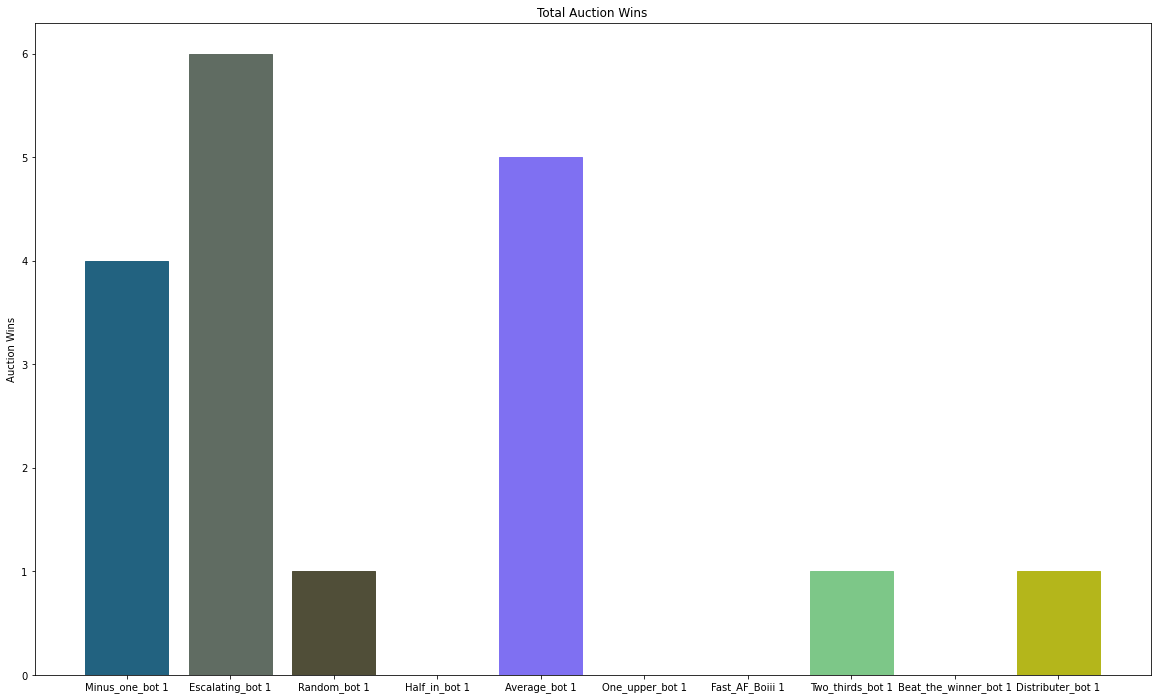

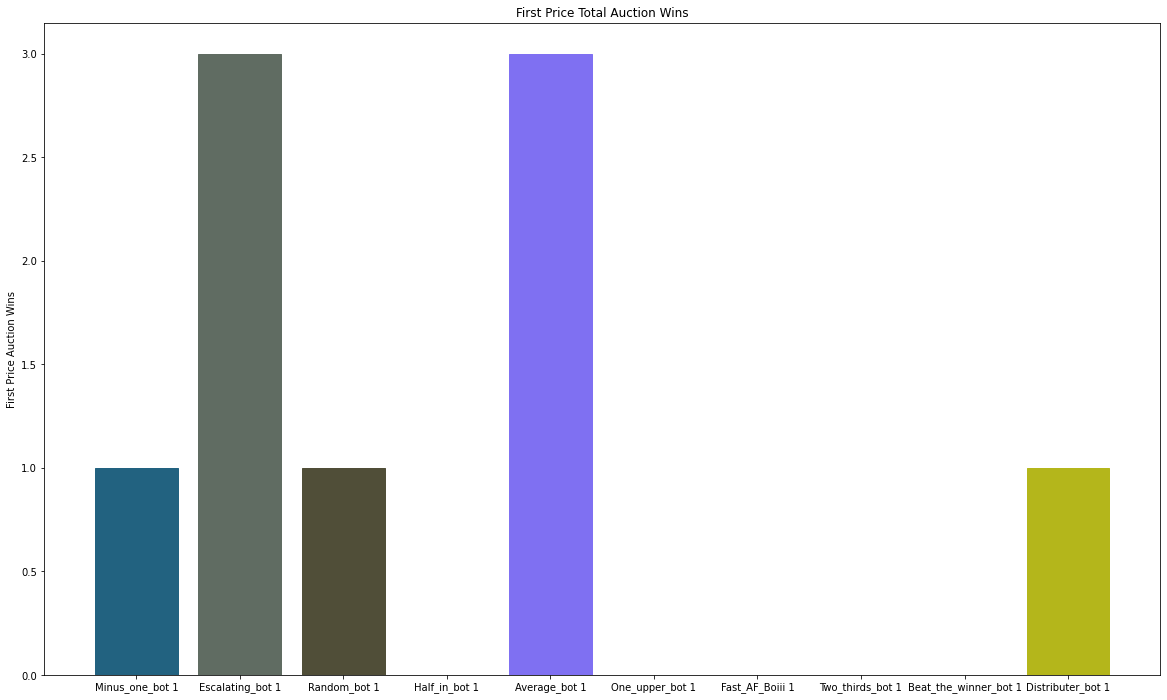

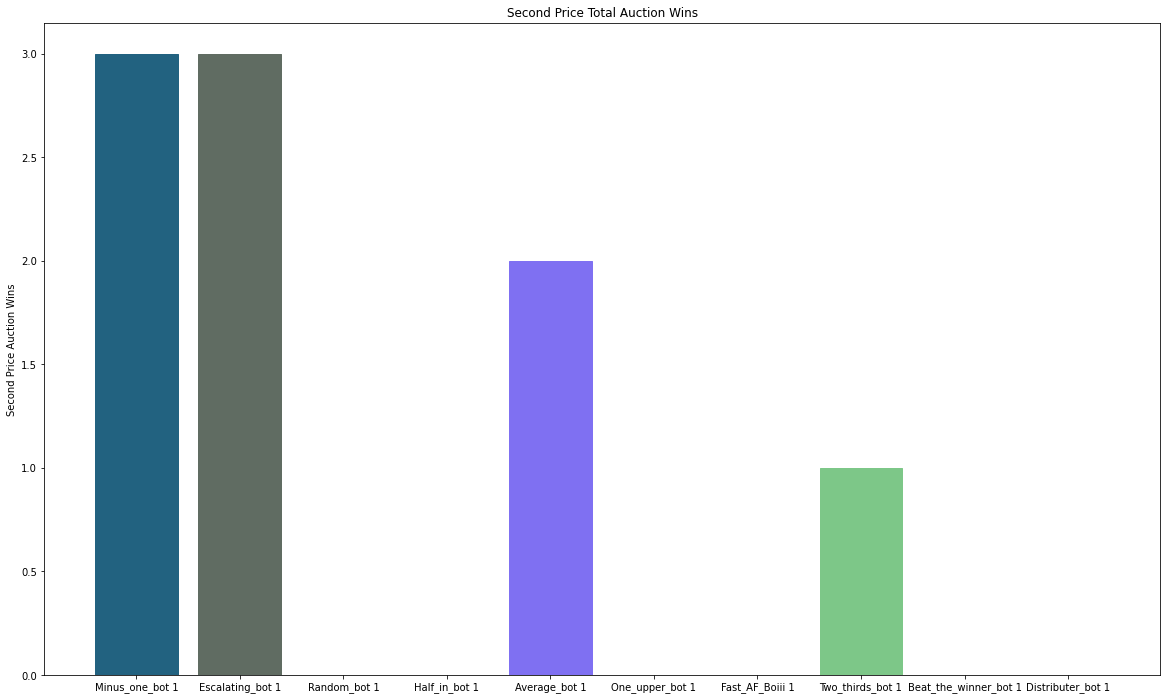

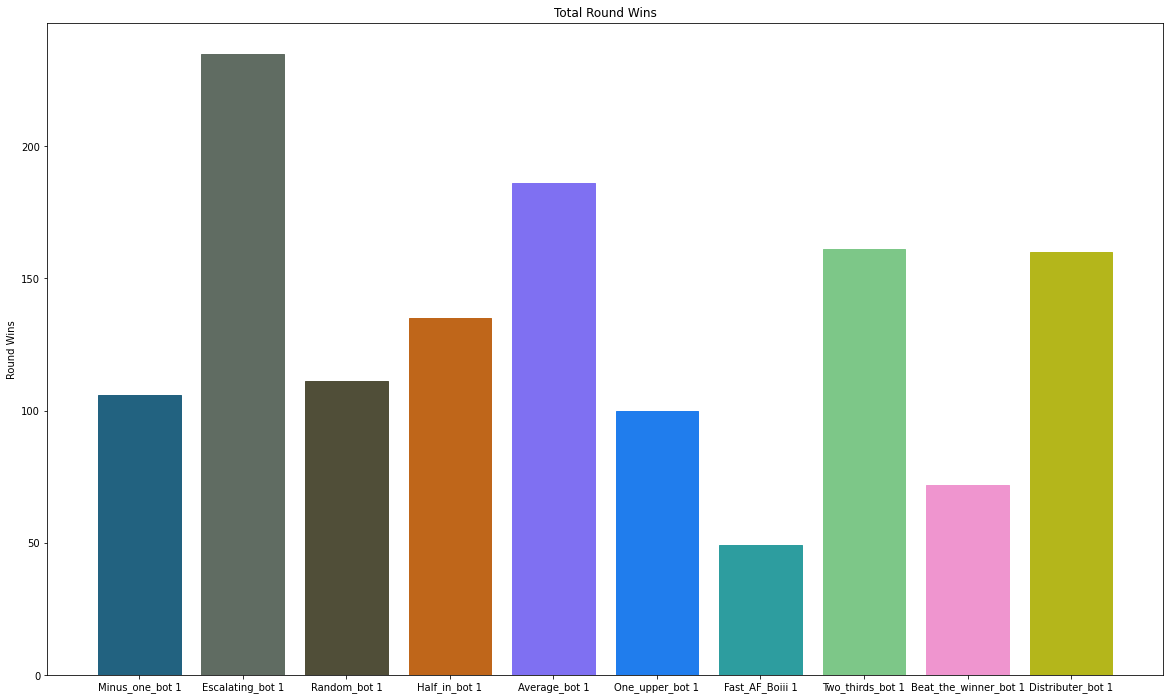

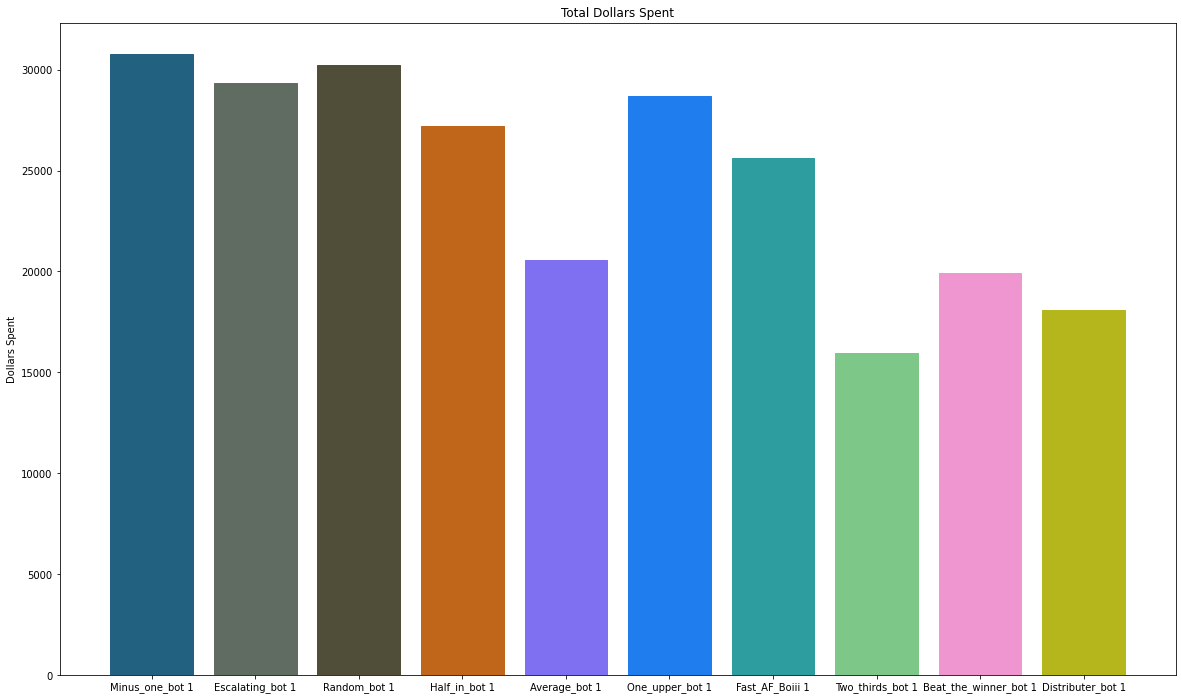

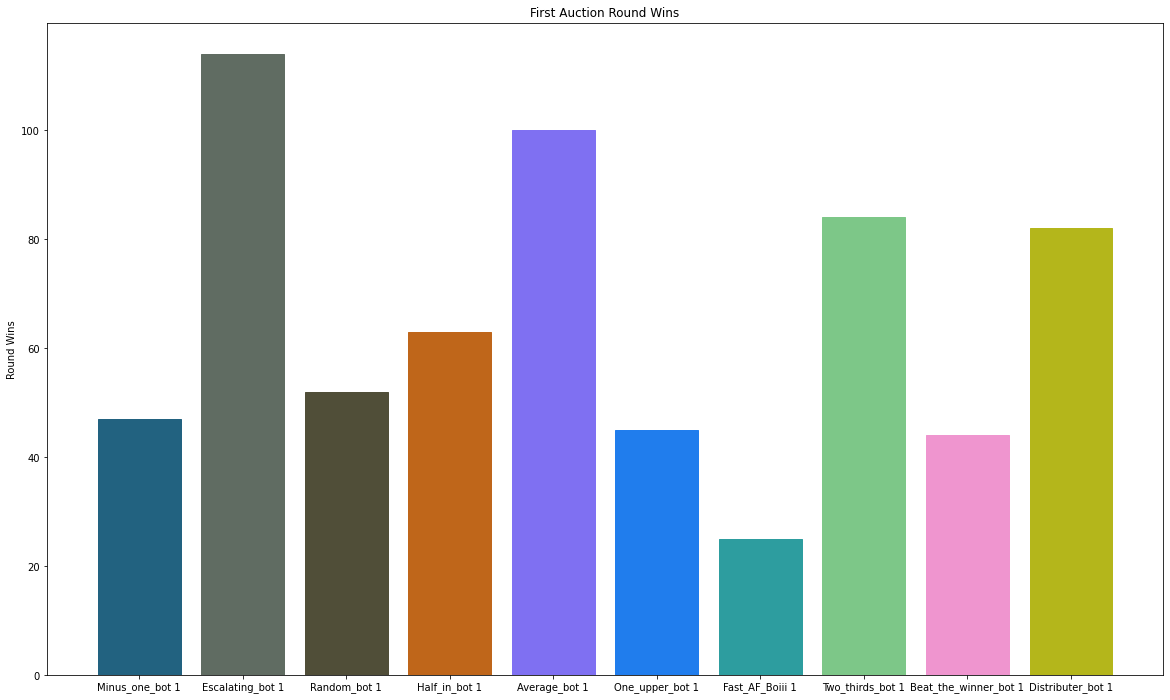

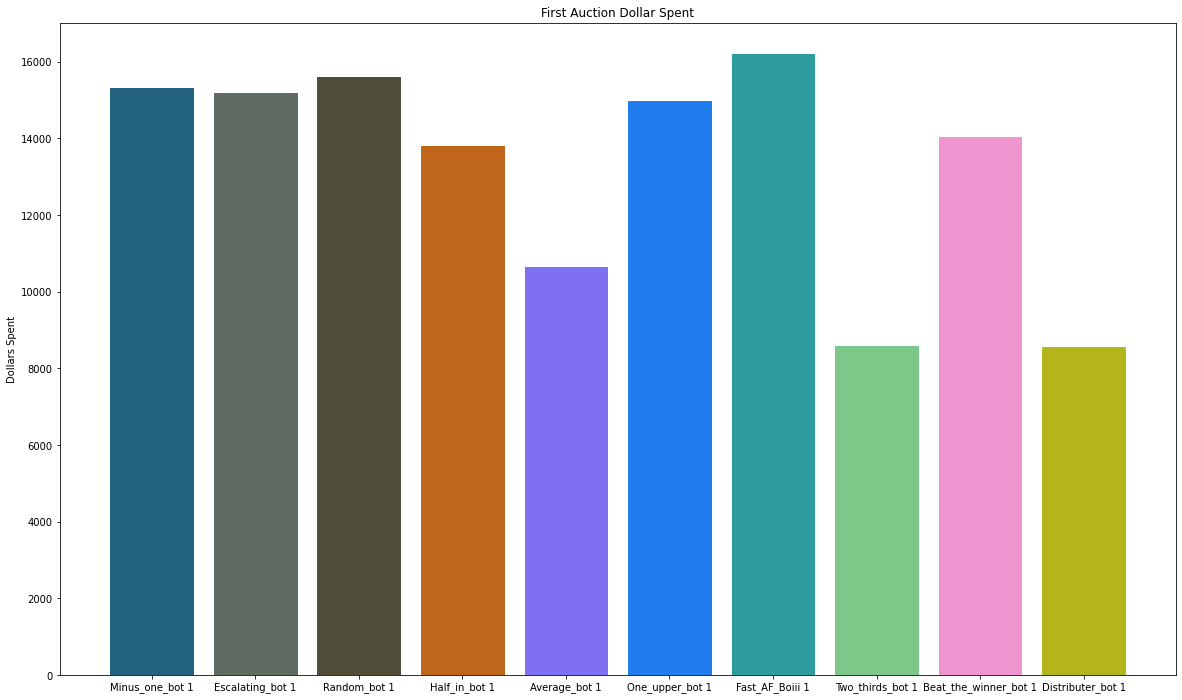

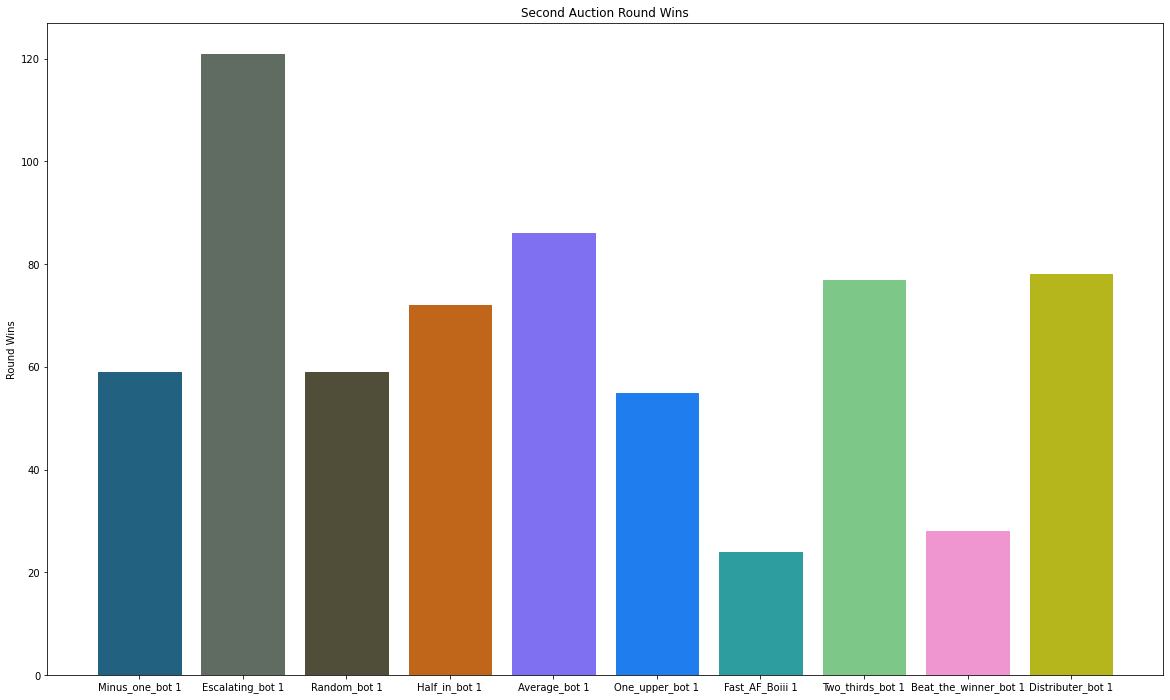

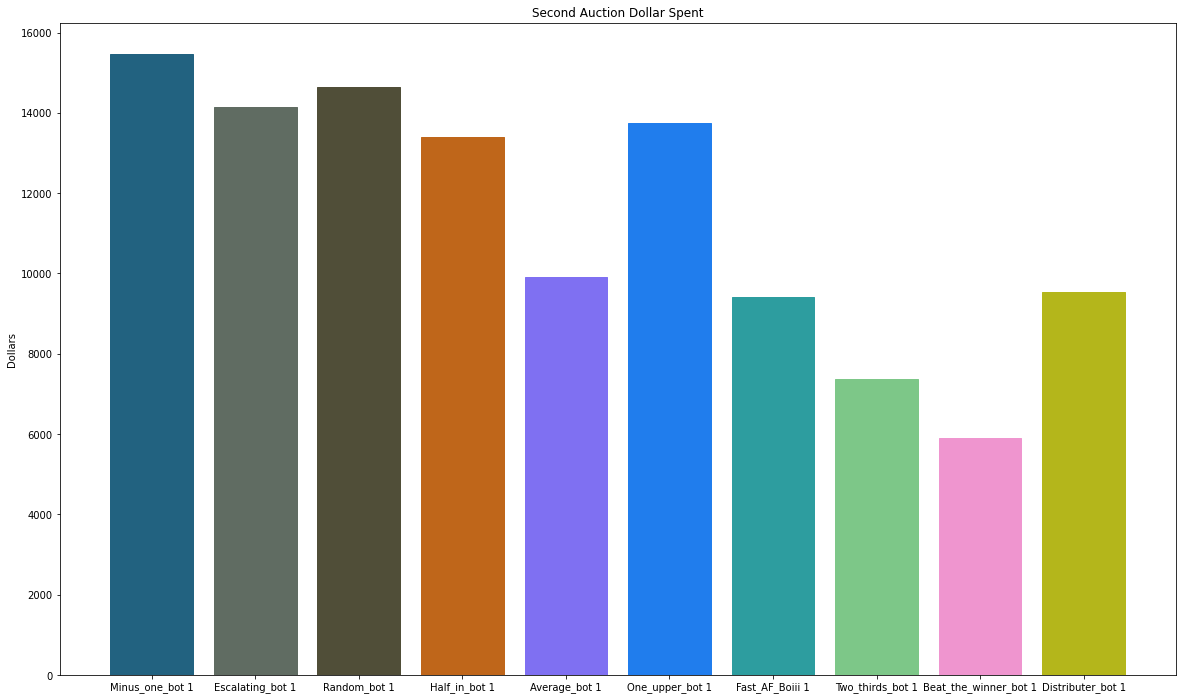

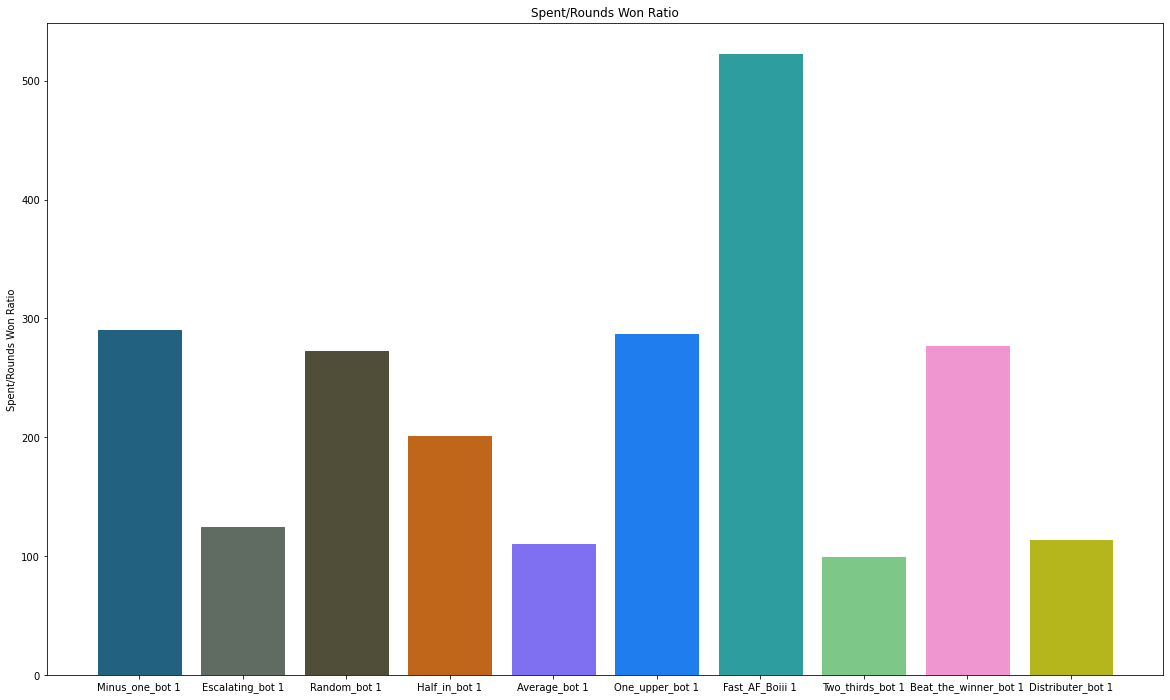

In [ ]:
bar_plot_dictionaries(stoo_wins,stoo_first_wins,stoo_second_wins,stoo_score,stoo_spent,stoo_first_score,stoo_first_spent,
                      stoo_second_score,stoo_second_spent,stoo_ratios)

# Code for a single evaluation and plotting

## Test 1.1

Bots:

1.   ***Minus_one_bot***
2.   ***Random_bot***
3.   ***Escalating_bot***
4.   ***Half_in_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***10***
*   Round payment: ***0***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Minus_one_bot(budget=budget))
    bot_list.append(Escalating_bot(budget=budget))
    bot_list.append(Random_bot(budget=budget))
    bot_list.append(Half_in_bot(budget=budget))
    
    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Half_in_bot 1        Score: 4      Total: 400
Escalating_bot 1     Score: 3      Total: 364
Random_bot 1         Score: 2      Total: 379
Minus_one_bot 1      Score: 1      Total: 399


['Random_bot 1', 'Minus_one_bot 1', 'Escalating_bot 1', 'Half_in_bot 1']

['Random_bot 1', 'Minus_one_bot 1', 'Escalating_bot 1', 'Half_in_bot 1']

{'Half_in_bot 1': [4, 400], 'Escalating_bot 1': [3, 364], 'Random_bot 1': [2, 379], 'Minus_one_bot 1': [1, 399]}


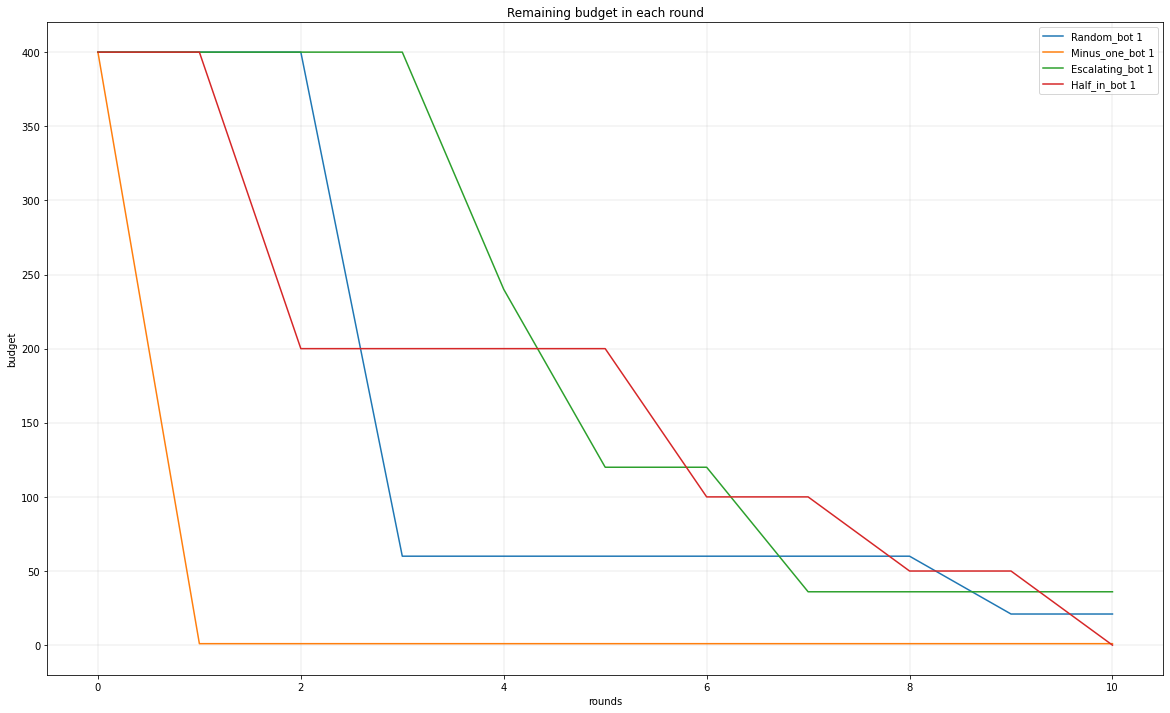

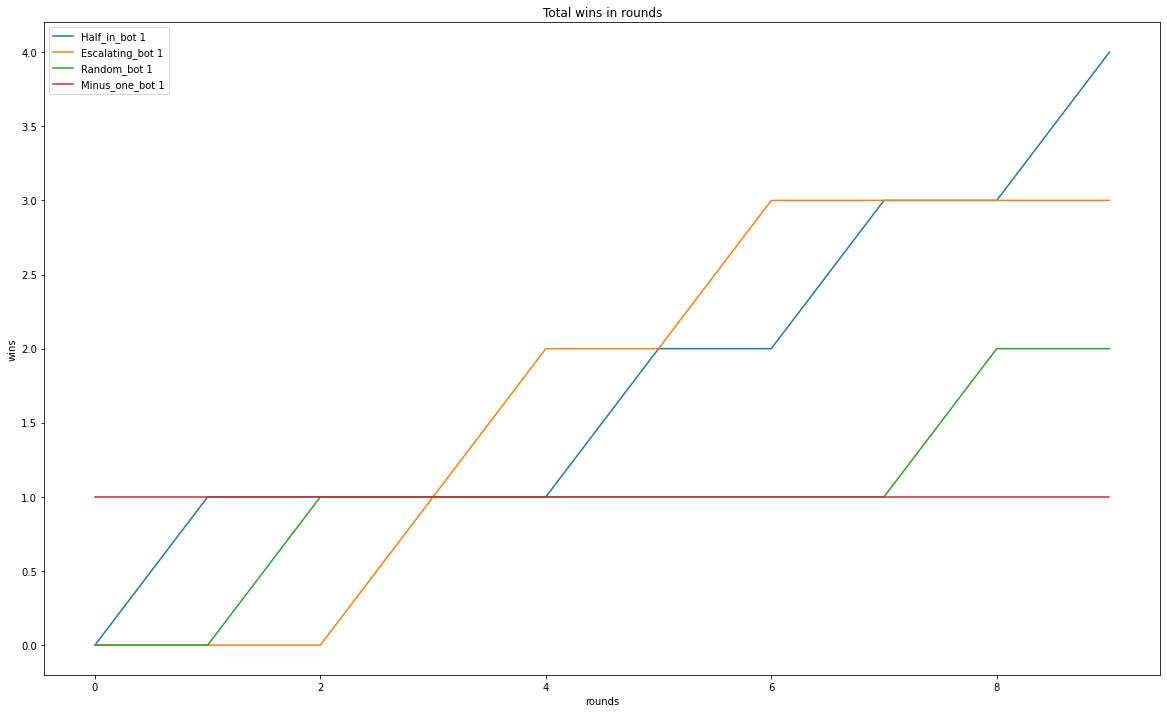

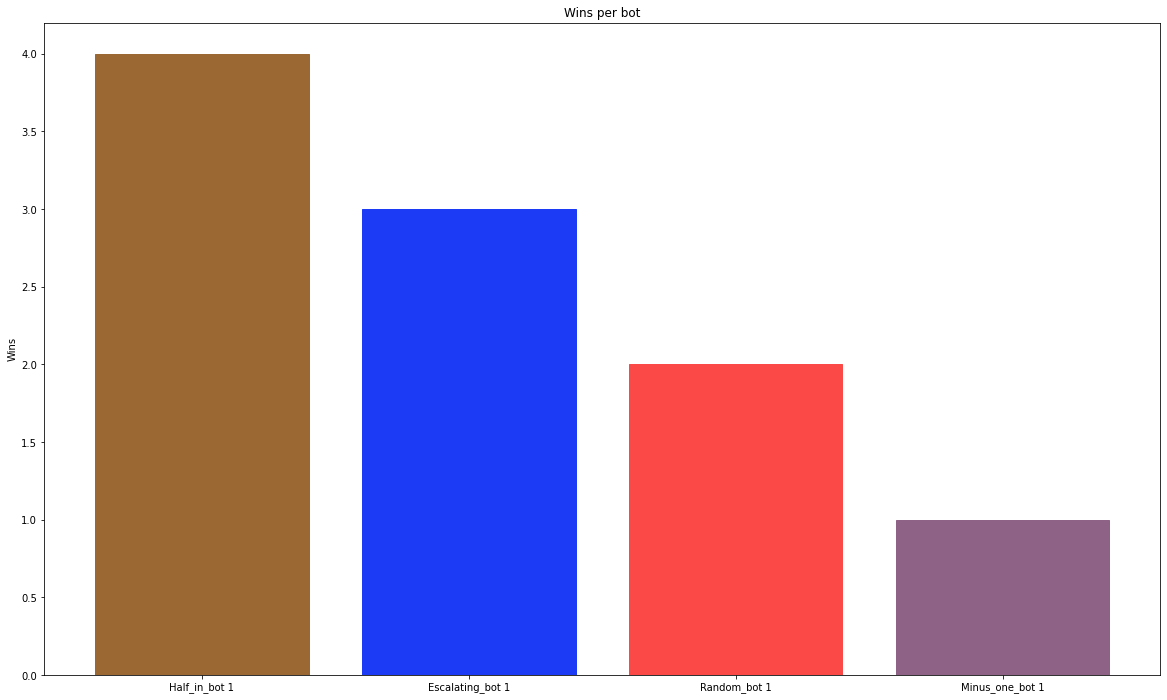

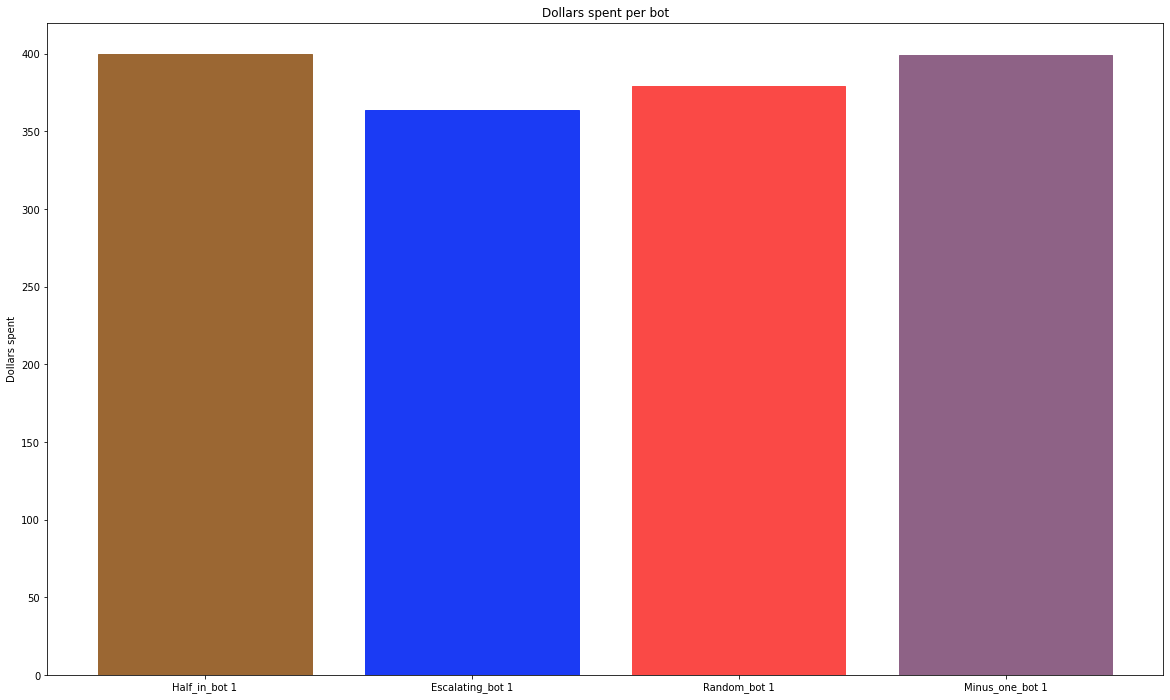

In [ ]:
num_of_rounds=10

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 0) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 1.2

Bots:

1.   ***Minus_one_bot***
2.   ***Random_bot***
3.   ***Escalating_bot***
4.   ***Half_in_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***50***
*   Round payment: ***0***
*   Budget: ***1000***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 1000
    bot_list.append(Minus_one_bot(budget=budget))
    bot_list.append(Escalating_bot(budget=budget))
    bot_list.append(Random_bot(budget=budget))
    bot_list.append(Half_in_bot(budget=budget))
    # bot_list.append(Average_bot(budget=budget))
    # bot_list.append(One_upper_bot(budget=budget))
    # bot_list.append(Fast_AF_Boiii(budget=budget))
    # bot_list.append(Two_thirds_bot(budget=budget))
    # bot_list.append(Beat_the_winner_bot(budget=budget))
    # bot_list.append(Distributer_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Escalating_bot 1     Score: 16     Total: 999
Half_in_bot 1        Score: 11     Total: 1000
Random_bot 1         Score: 6      Total: 1000
Minus_one_bot 1      Score: 1      Total: 999


['Random_bot 1', 'Minus_one_bot 1', 'Escalating_bot 1', 'Half_in_bot 1']

{'Escalating_bot 1': [16, 999], 'Half_in_bot 1': [11, 1000], 'Random_bot 1': [6, 1000], 'Minus_one_bot 1': [1, 999]}


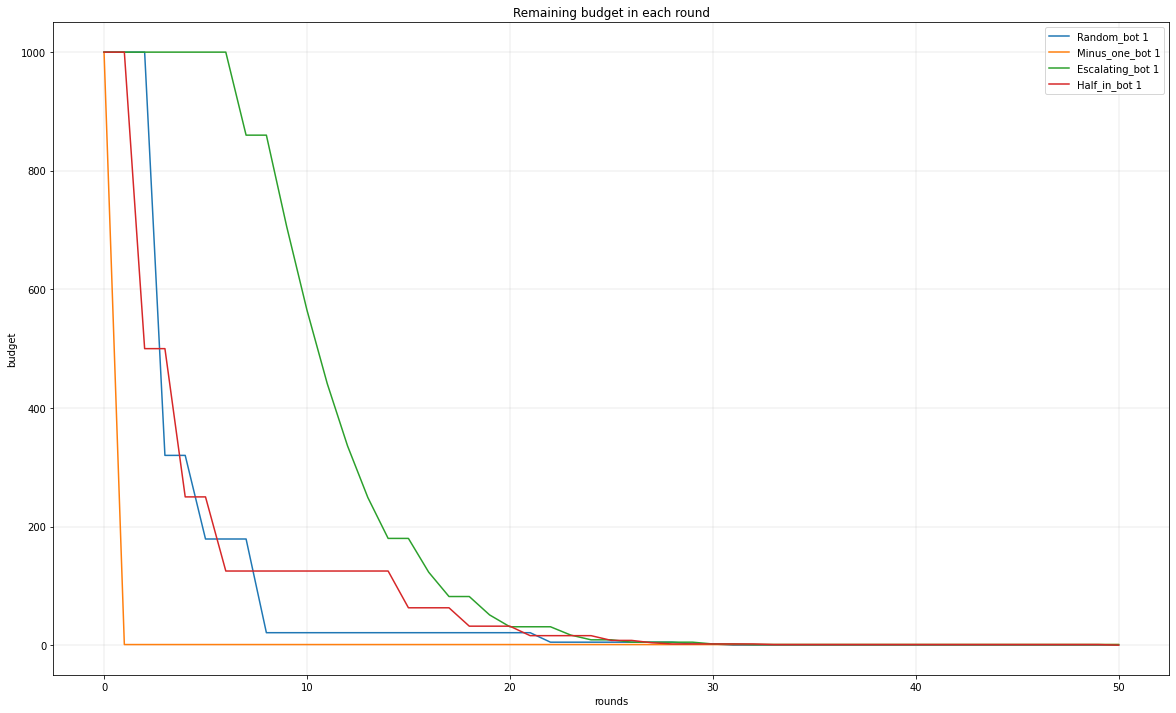

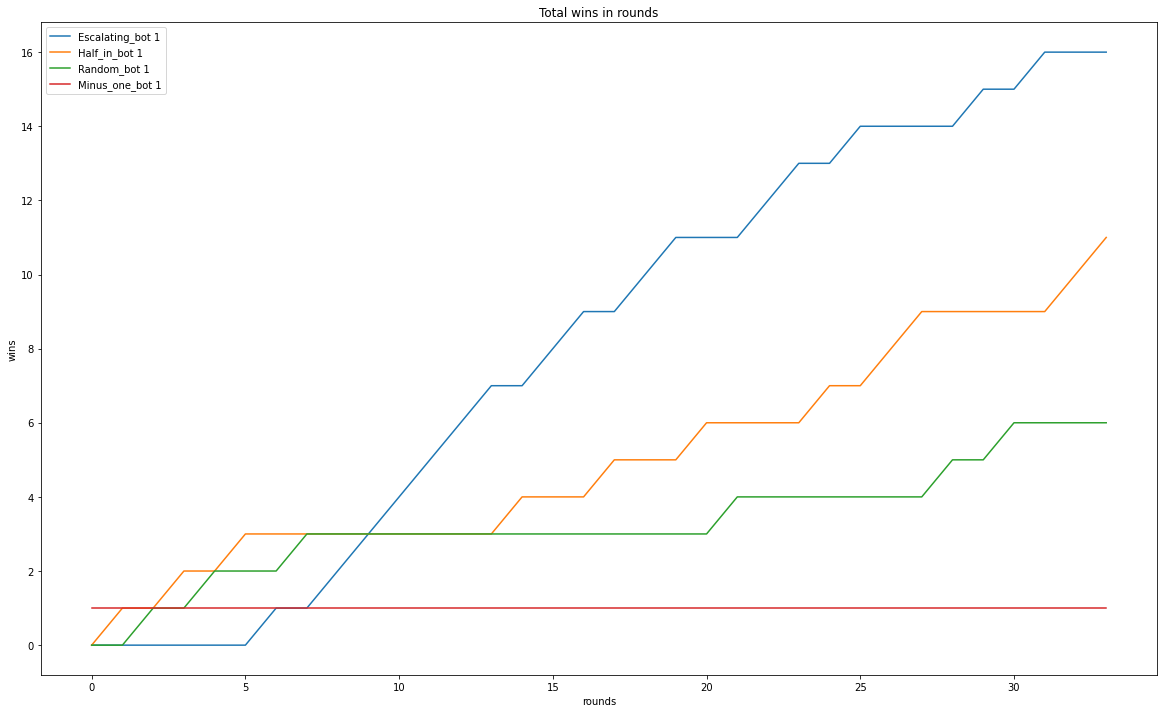

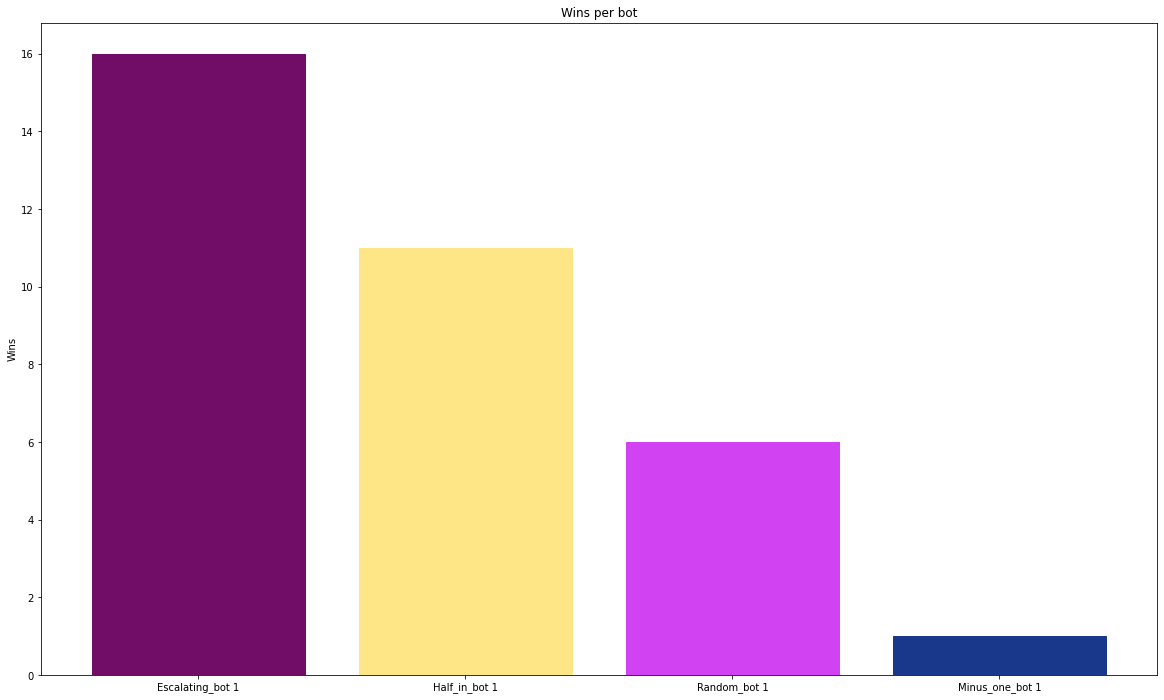

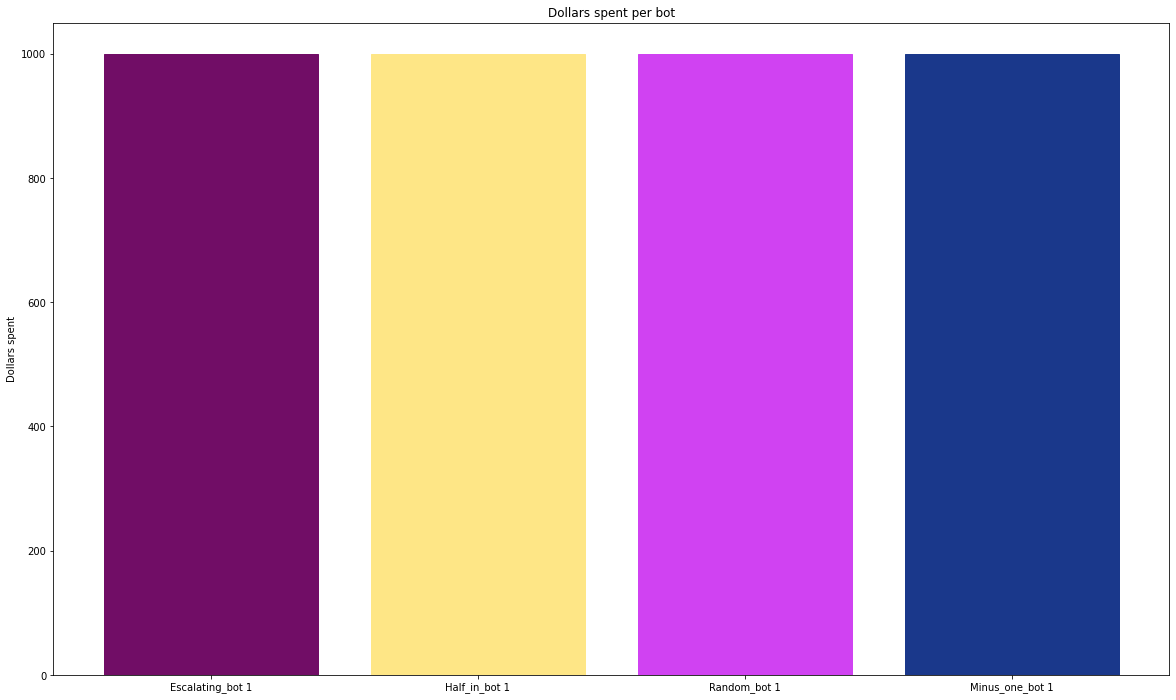

In [ ]:
num_of_rounds=50

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 0) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 2.1

Bots:

1.   ***Average_bot***
2.   ***One_upper_bot***
3.   ***Fast_AF_Boiii***
4.   ***Two_thirds_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***20***
*   Round payment: ***0***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Average_bot(budget=budget))
    bot_list.append(One_upper_bot(budget=budget))
    bot_list.append(Fast_AF_Boiii(budget=budget))
    bot_list.append(Two_thirds_bot(budget=budget))
    # bot_list.append(Beat_the_winner_bot(budget=budget))
    # bot_list.append(Distributer_bot(budget=budget))
    
    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Average_bot 1        Score: 6      Total: 310
Two_thirds_bot 1     Score: 5      Total: 250
One_upper_bot 1      Score: 5      Total: 400
Fast_AF_Boiii 1      Score: 4      Total: 400


['Fast_AF_Boiii 1', 'Average_bot 1', 'One_upper_bot 1', 'Two_thirds_bot 1']

{'Average_bot 1': [6, 310], 'Two_thirds_bot 1': [5, 250], 'One_upper_bot 1': [5, 400], 'Fast_AF_Boiii 1': [4, 400]}


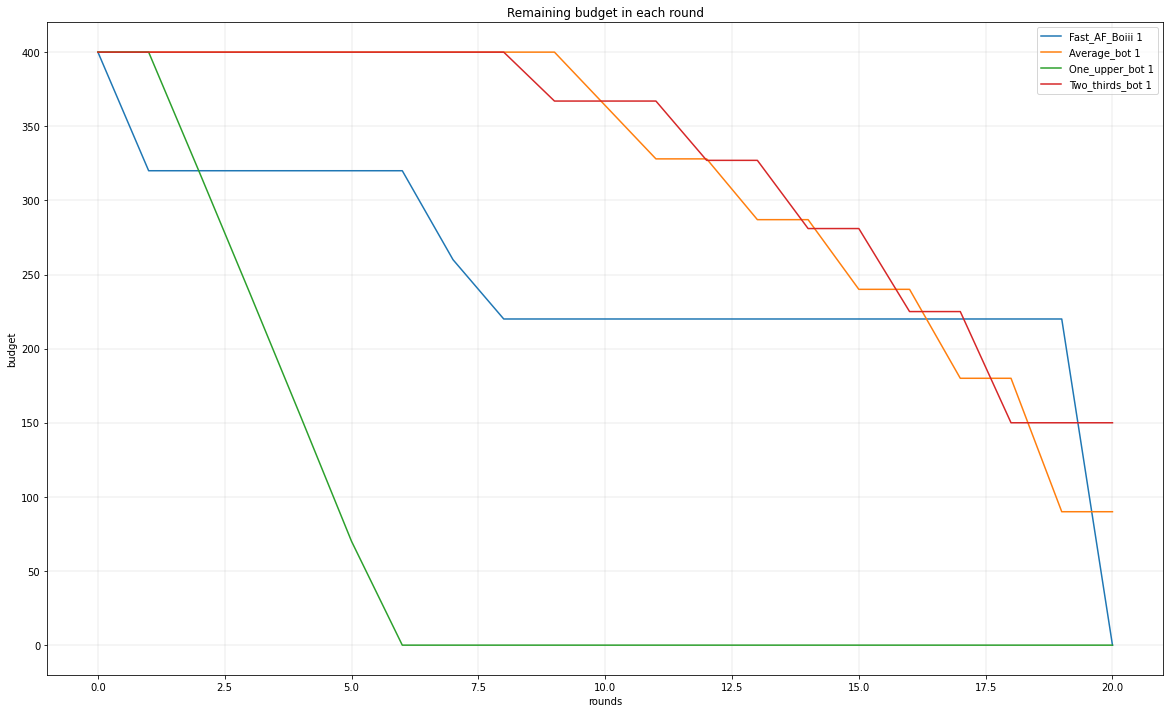

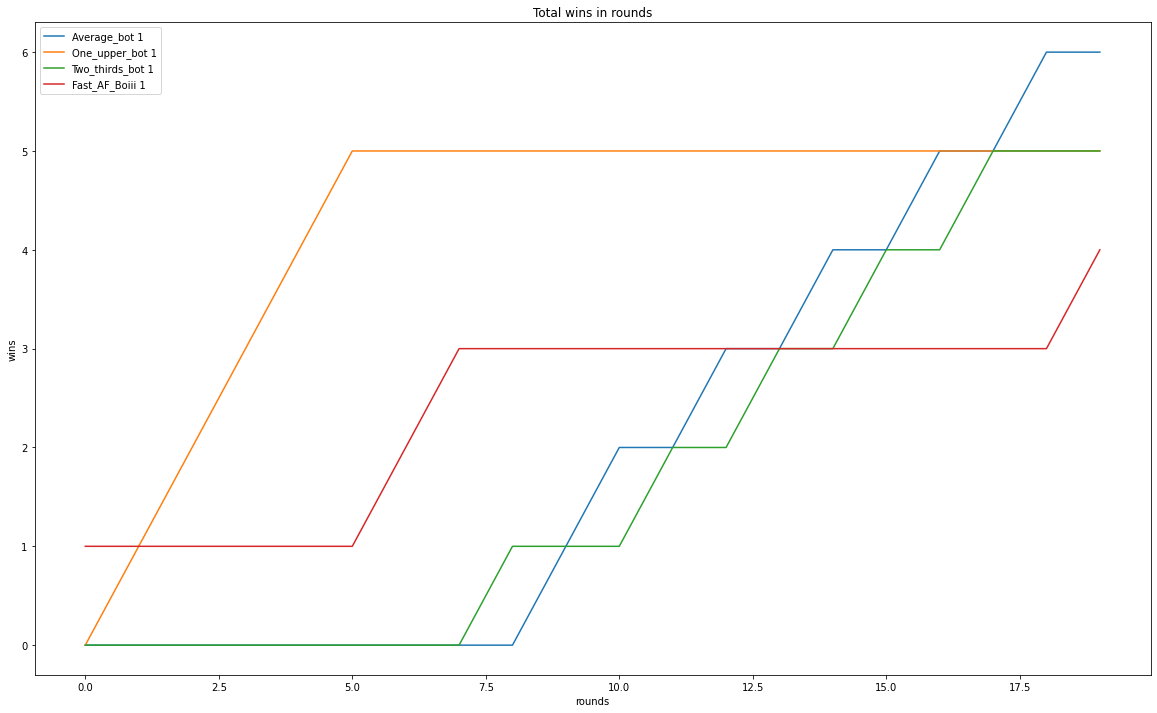

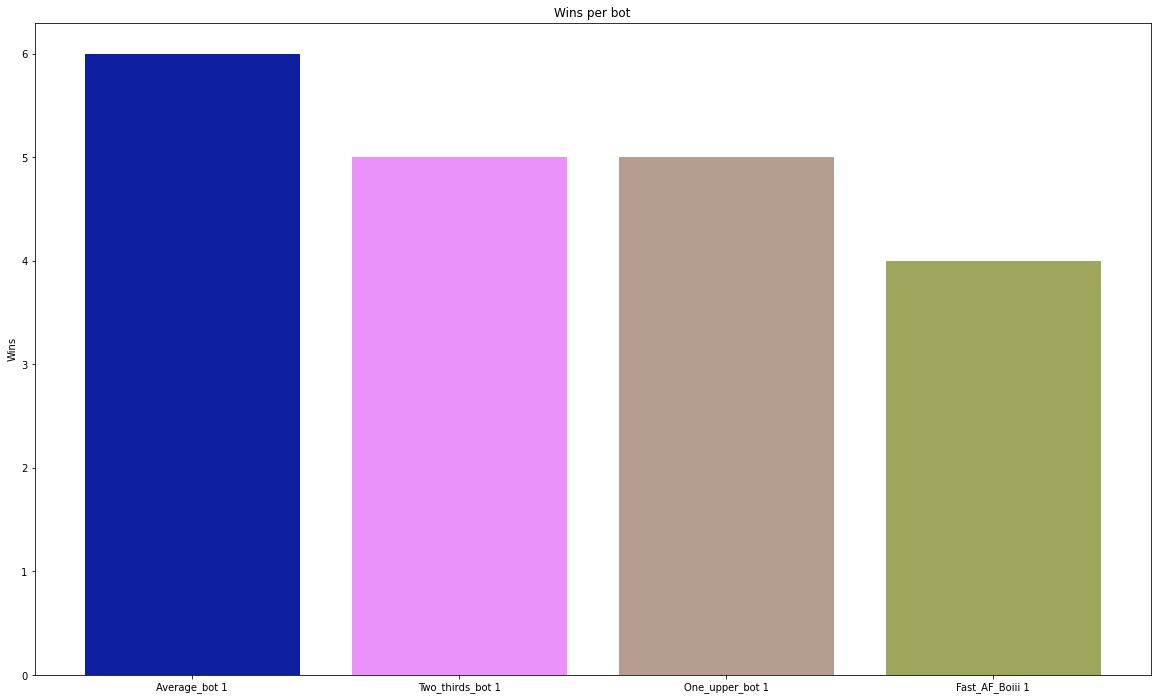

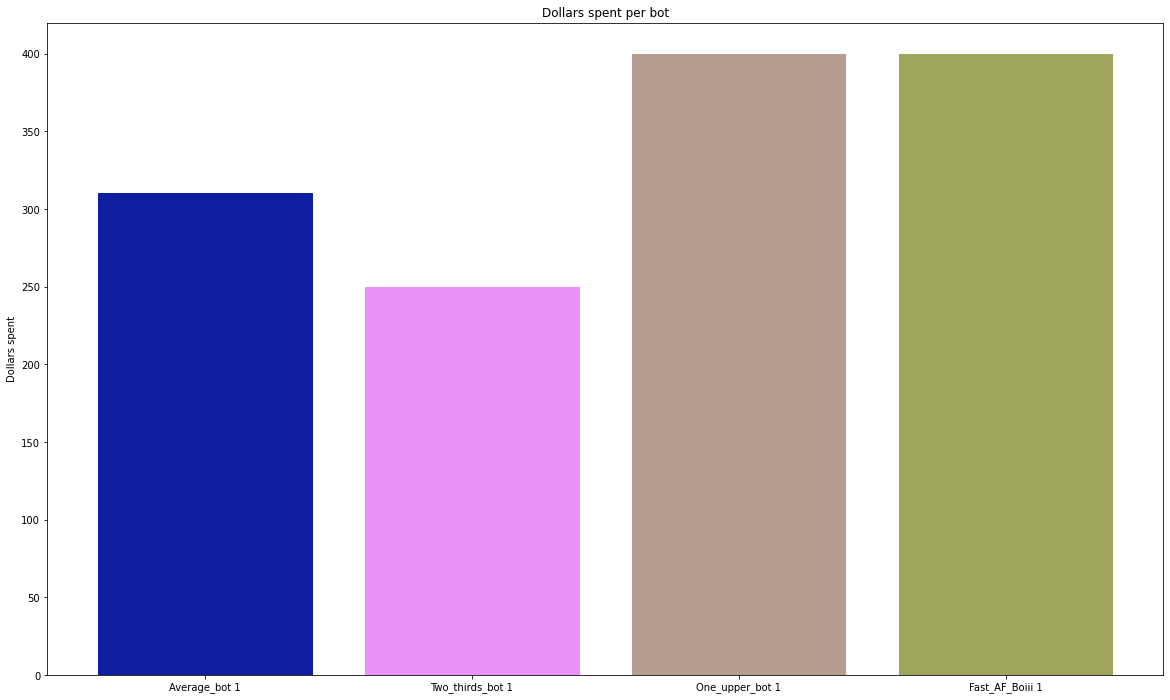

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spentn, infos = run_auctions(type_of_auctions, num_of_rounds, 0) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 2.2

Bots:

1.   ***Average_bot***
2.   ***One_upper_bot***
3.   ***Fast_AF_Boiii***
4.   ***Two_thirds_bot***

Scenario:

*   Protocol: ***Second Price***
*   Rounds: ***20***
*   Round payment: ***0***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400

    bot_list.append(Average_bot(budget=budget))
    bot_list.append(One_upper_bot(budget=budget))
    bot_list.append(Fast_AF_Boiii(budget=budget))
    bot_list.append(Two_thirds_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Average_bot 1        Score: 8      Total: 311
Two_thirds_bot 1     Score: 7      Total: 248
Fast_AF_Boiii 1      Score: 3      Total: 63
One_upper_bot 1      Score: 2      Total: 360


['Fast_AF_Boiii 1', 'Average_bot 1', 'One_upper_bot 1', 'Two_thirds_bot 1']

{'Average_bot 1': [8, 311], 'Two_thirds_bot 1': [7, 248], 'Fast_AF_Boiii 1': [3, 63], 'One_upper_bot 1': [2, 360]}


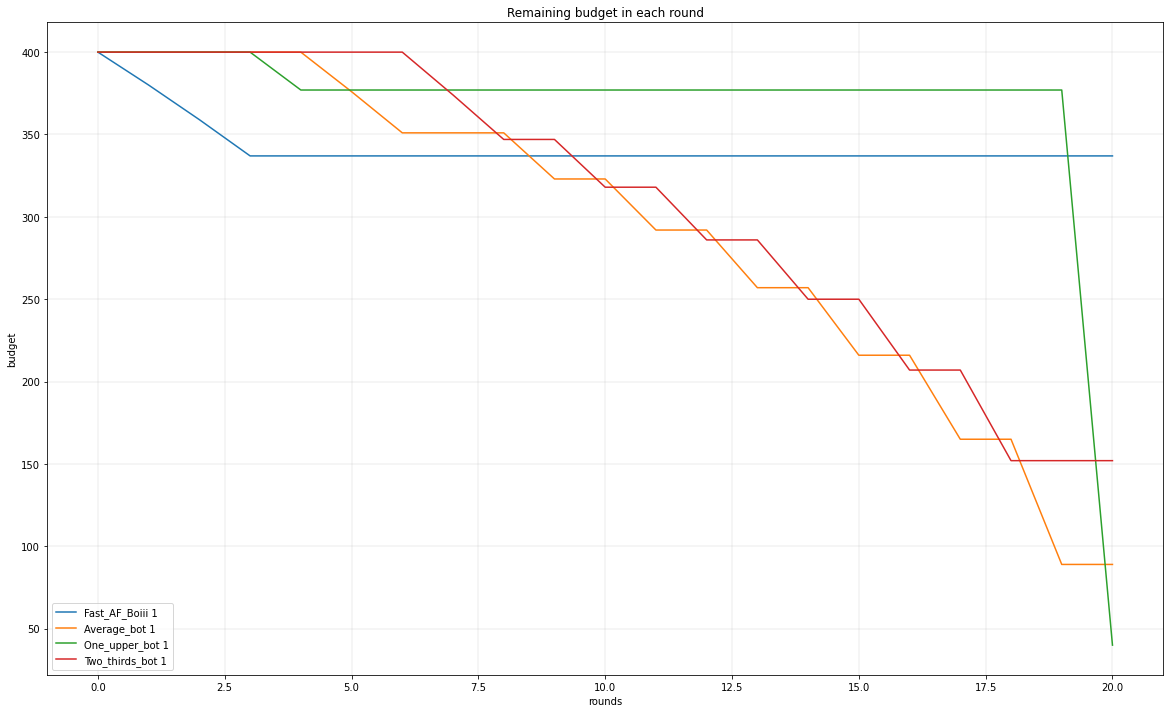

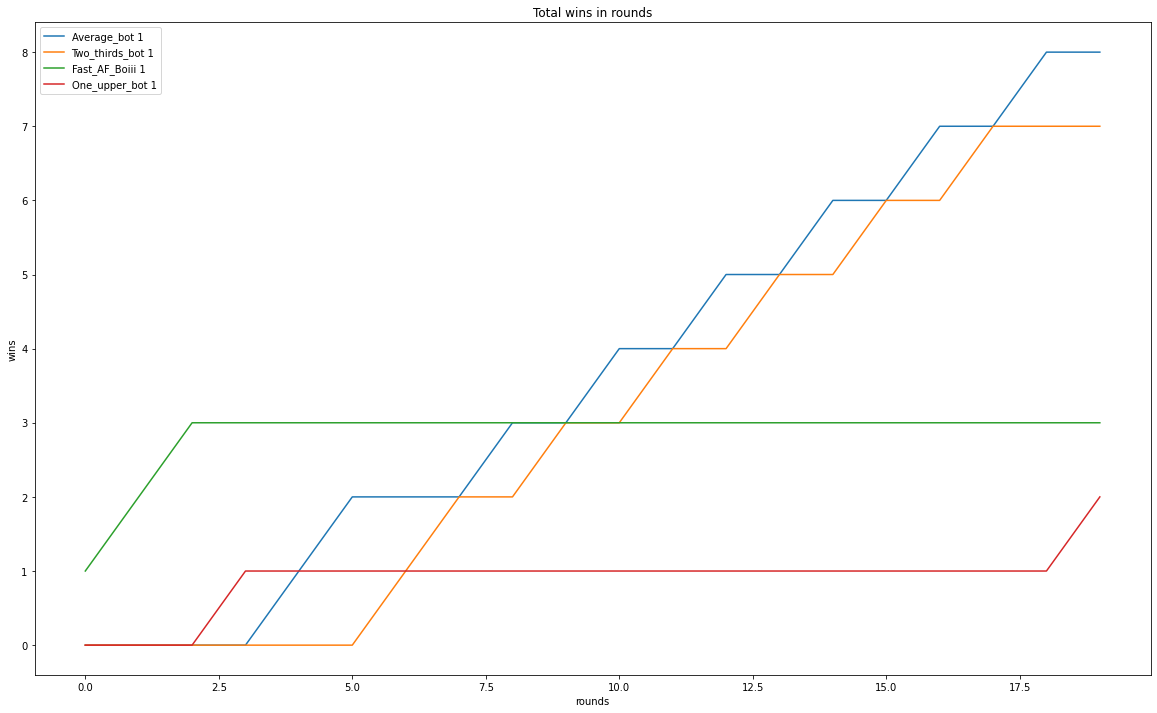

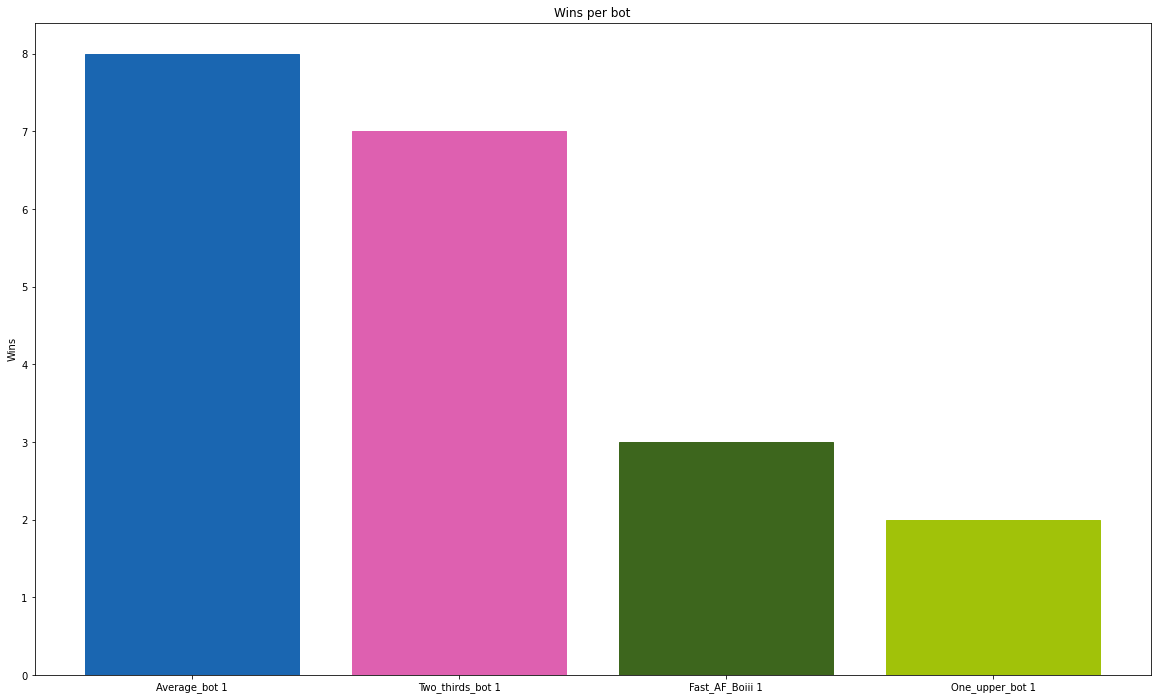

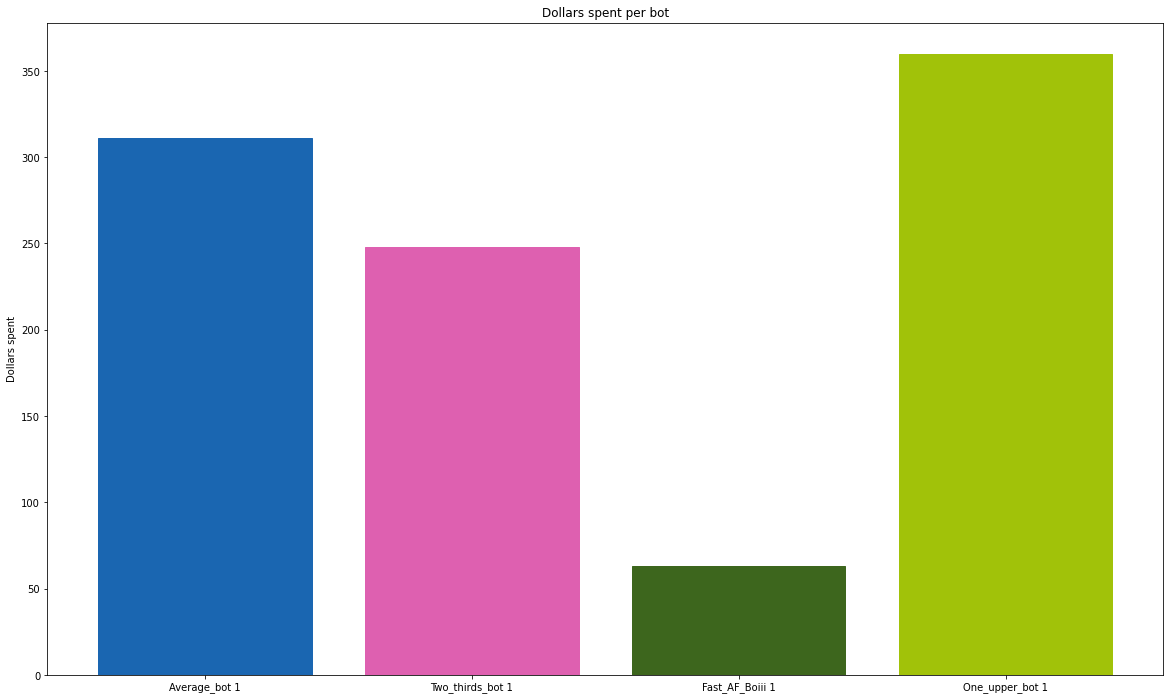

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=0
num_of_second_price_auctions=1

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 0) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)
graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 3.1

Bots:

1.   ***One_upper_bot***
2.   ***Random_bot***
3.   ***Beat_the_winner_bot***
4.   ***Distributer_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***50***
*   Round payment: ***50***
*   Budget: ***800***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 800
    bot_list.append(Random_bot(budget=budget))
    bot_list.append(One_upper_bot(budget=budget))
    bot_list.append(Beat_the_winner_bot(budget=budget))
    bot_list.append(Distributer_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

One_upper_bot 1      Score: 14     Total: 3141
Beat_the_winner_bot 1 Score: 12     Total: 2667
Random_bot 1         Score: 12     Total: 3196
Distributer_bot 1    Score: 12     Total: 3300


['Beat_the_winner_bot 1',
 'Random_bot 1',
 'One_upper_bot 1',
 'Distributer_bot 1']

{'One_upper_bot 1': [14, 3141], 'Beat_the_winner_bot 1': [12, 2667], 'Random_bot 1': [12, 3196], 'Distributer_bot 1': [12, 3300]}


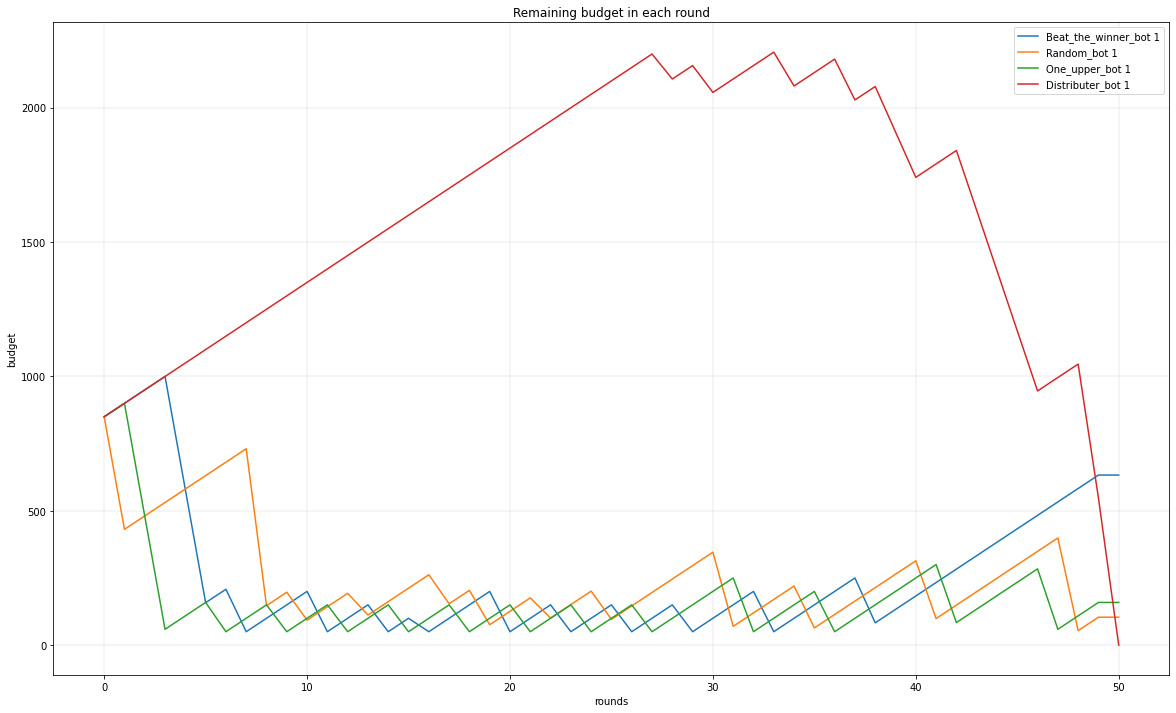

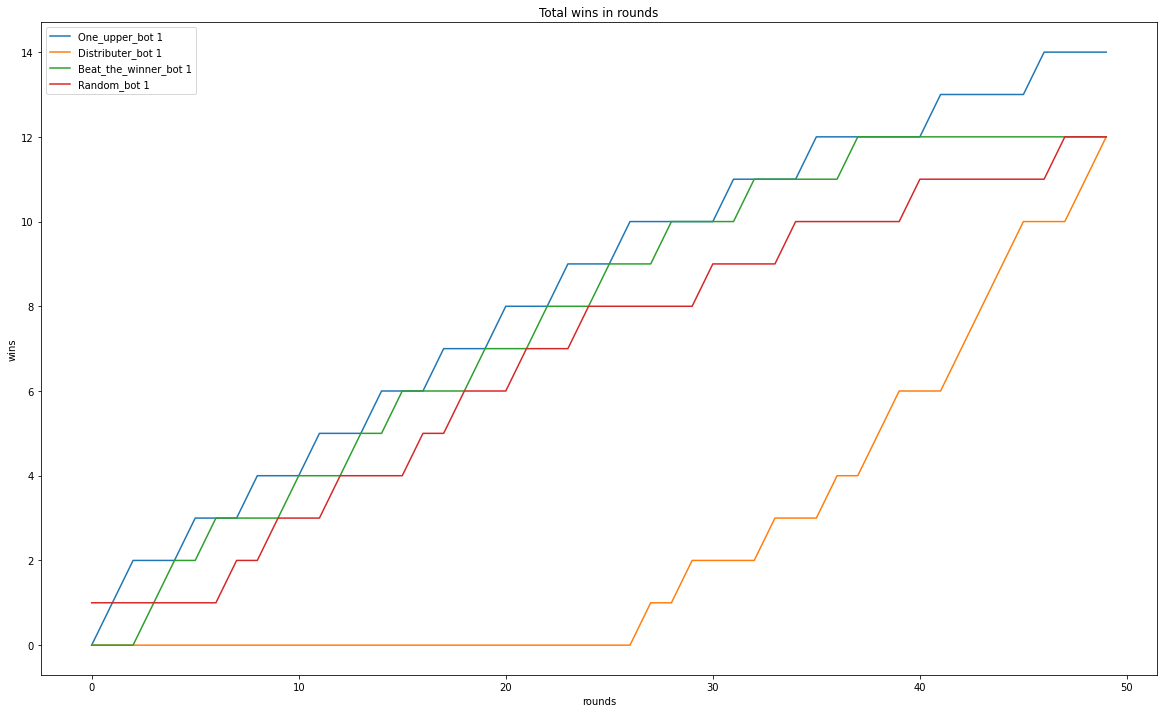

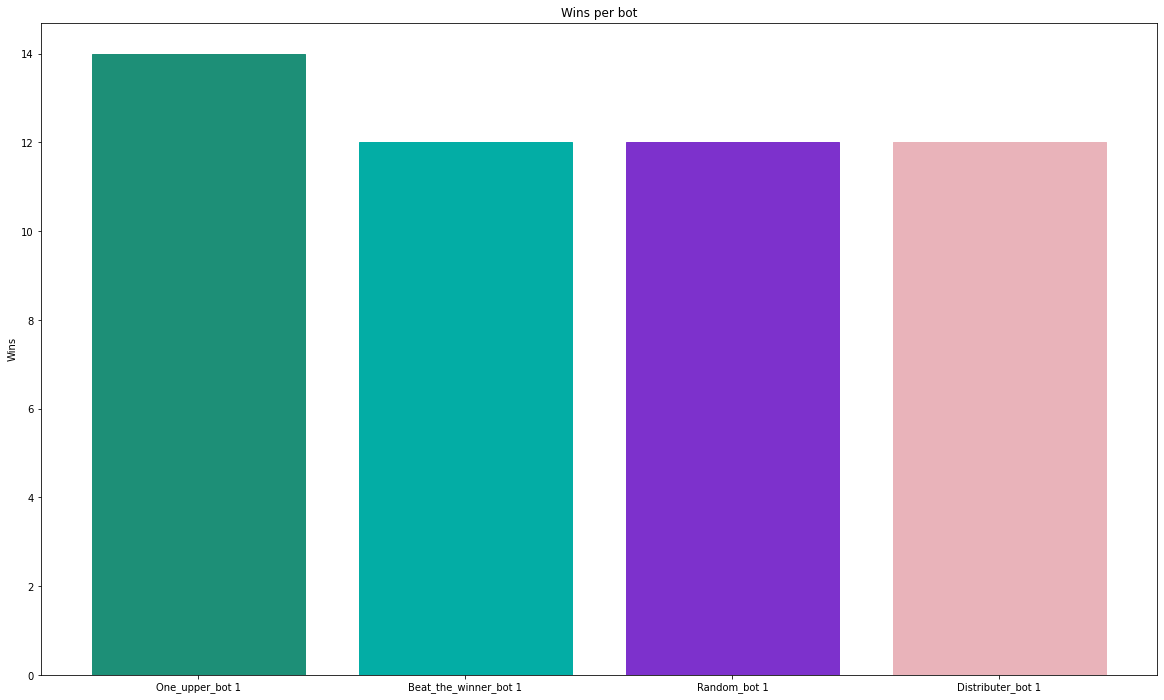

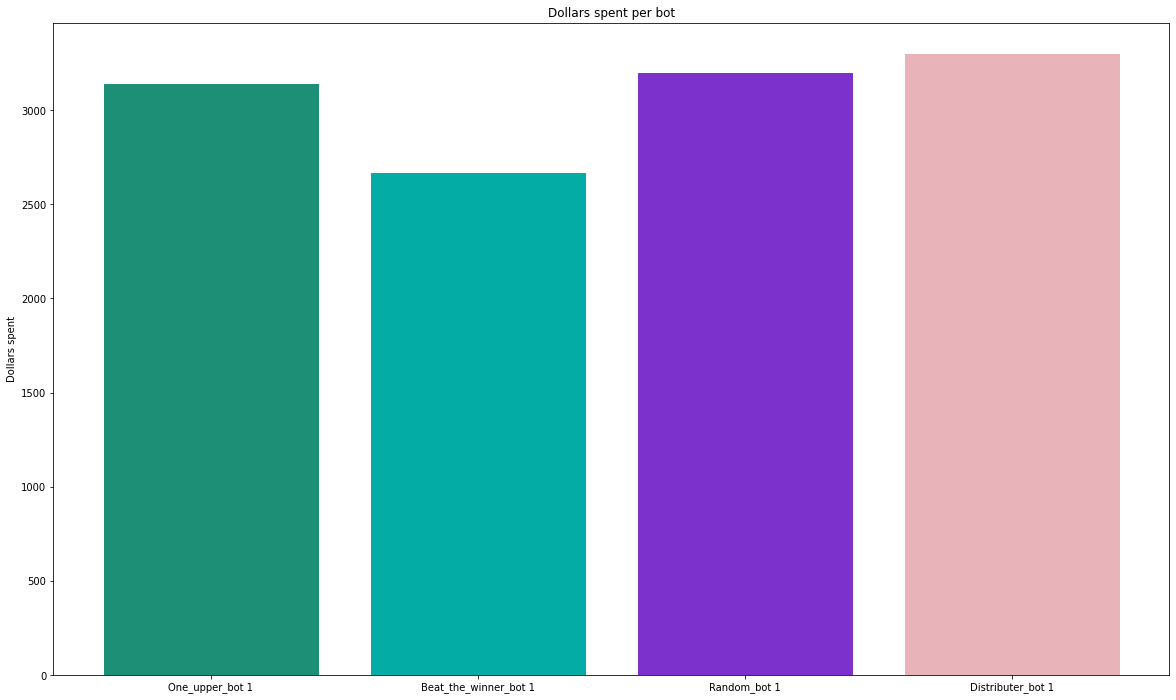

In [ ]:
num_of_rounds=50

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 50) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 3.2

Bots:

1.   ***One_upper_bot***
2.   ***Random_bot***
3.   ***Beat_the_winner_bot***
4.   ***Distributer_bot***

Scenario:

*   Protocol: ***Second Price***
*   Rounds: ***50***
*   Round payment: ***50***
*   Budget: ***800***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 800
    bot_list.append(Random_bot(budget=budget))
    bot_list.append(One_upper_bot(budget=budget))
    bot_list.append(Beat_the_winner_bot(budget=budget))
    bot_list.append(Distributer_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Distributer_bot 1    Score: 15     Total: 2793
Beat_the_winner_bot 1 Score: 14     Total: 2501
Random_bot 1         Score: 13     Total: 2797
One_upper_bot 1      Score: 8      Total: 2163


['Beat_the_winner_bot 1',
 'Random_bot 1',
 'One_upper_bot 1',
 'Distributer_bot 1']

{'Distributer_bot 1': [15, 2793], 'Beat_the_winner_bot 1': [14, 2501], 'Random_bot 1': [13, 2797], 'One_upper_bot 1': [8, 2163]}


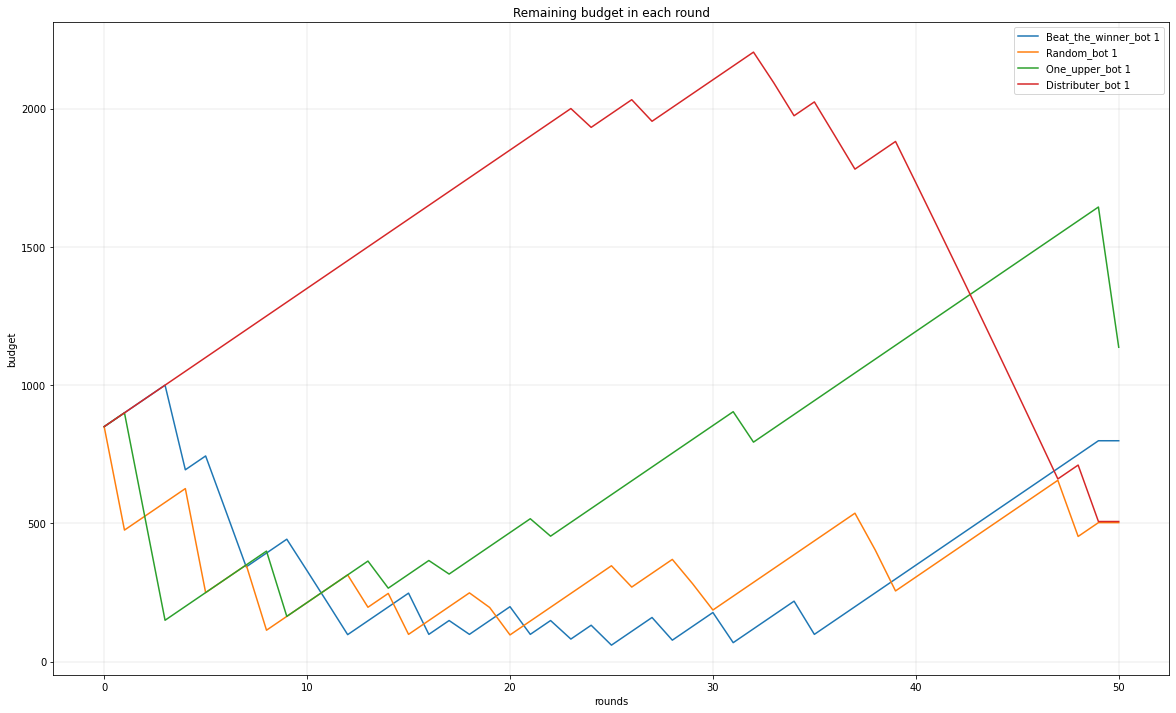

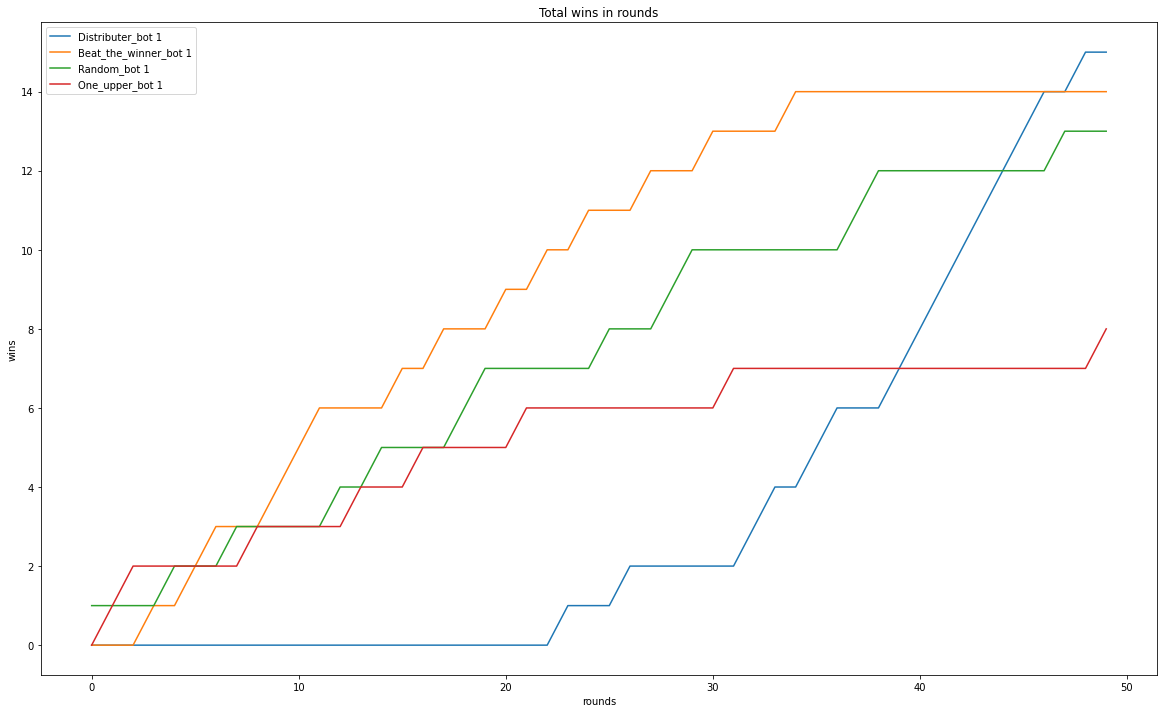

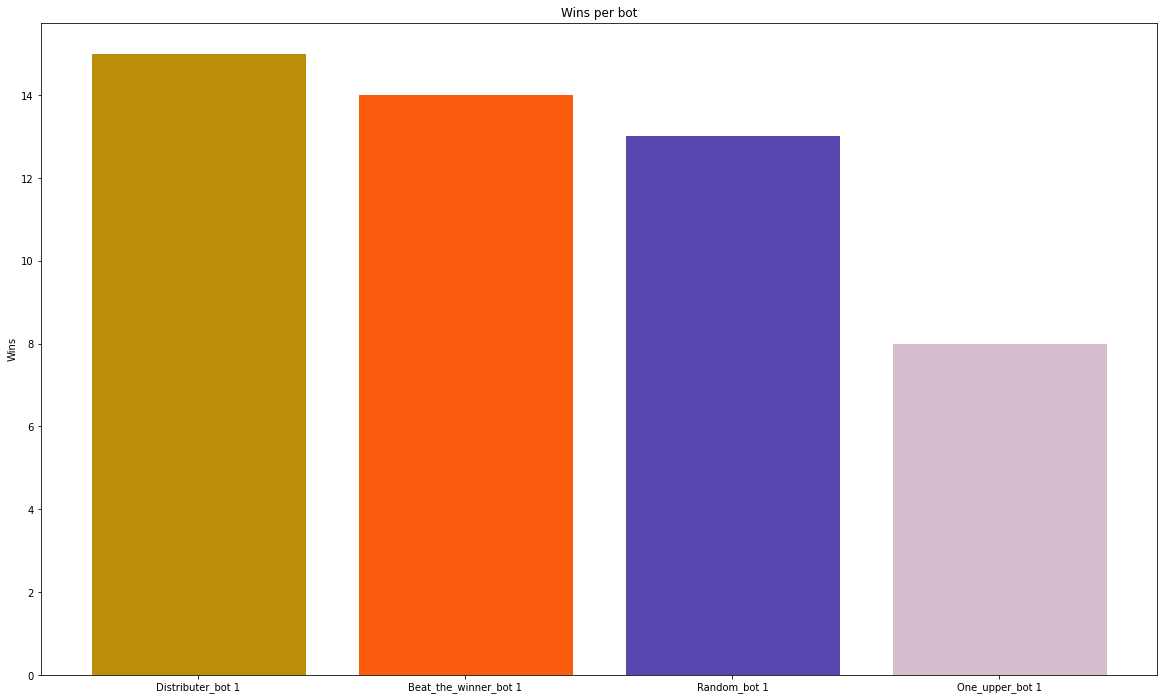

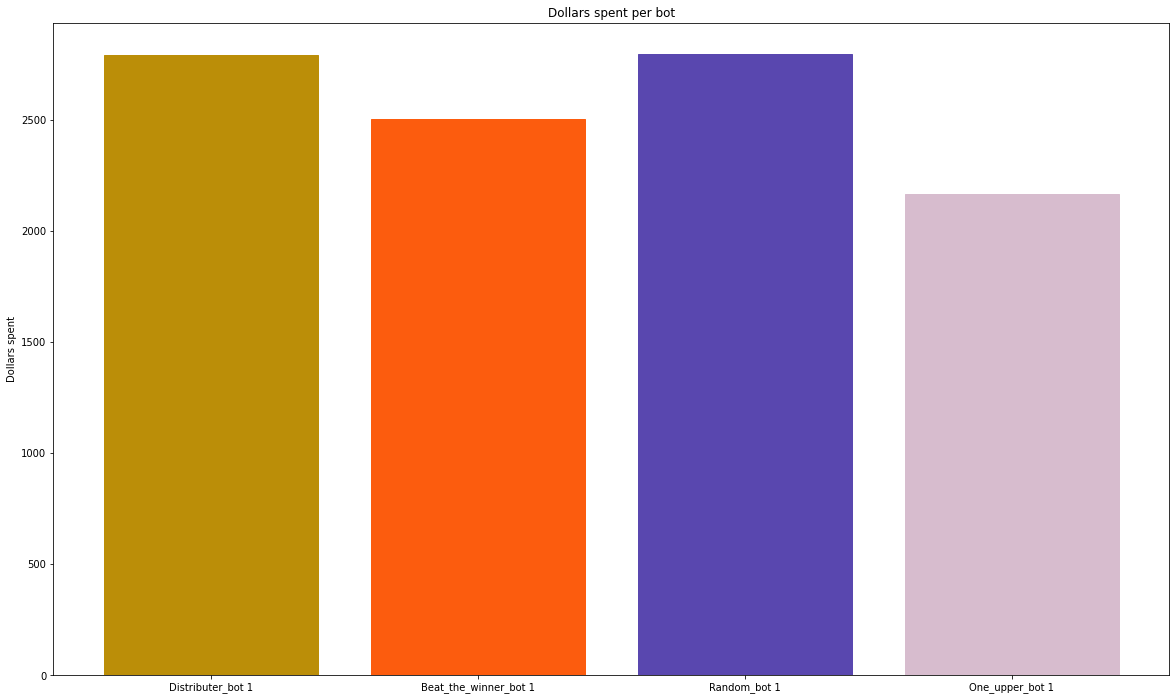

In [ ]:
num_of_rounds=50
num_of_first_price_auctions=0
num_of_second_price_auctions=1

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 50) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 4.1

Bots:

1.   ***Distributer_bot***
2.   ***Fast_AF_Boiii***
3.   ***Escalating_bot***
4.   ***Two_thirds_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***20***
*   Round payment: ***0***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Escalating_bot(budget=budget))
    bot_list.append(Fast_AF_Boiii(budget=budget))
    bot_list.append(Two_thirds_bot(budget=budget))
    bot_list.append(Distributer_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Two_thirds_bot 1     Score: 7      Total: 293
Escalating_bot 1     Score: 6      Total: 357
Fast_AF_Boiii 1      Score: 4      Total: 400
Distributer_bot 1    Score: 3      Total: 324


['Two_thirds_bot 1',
 'Escalating_bot 1',
 'Fast_AF_Boiii 1',
 'Distributer_bot 1']

{'Two_thirds_bot 1': [7, 293], 'Escalating_bot 1': [6, 357], 'Fast_AF_Boiii 1': [4, 400], 'Distributer_bot 1': [3, 324]}


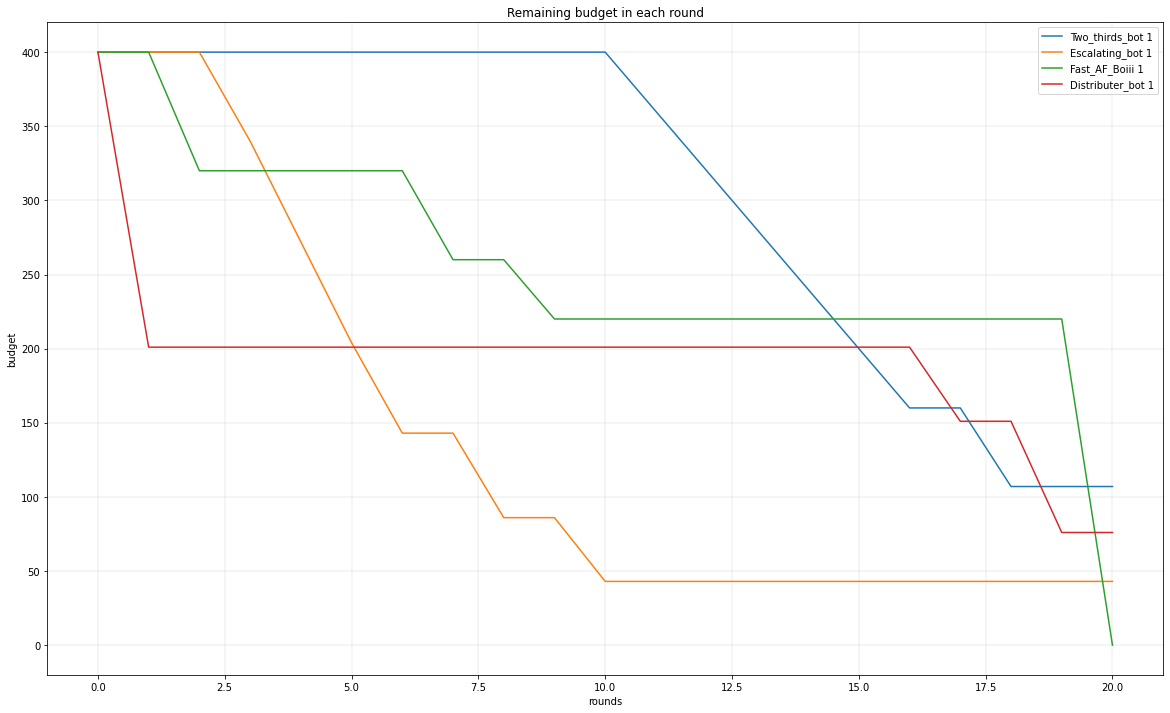

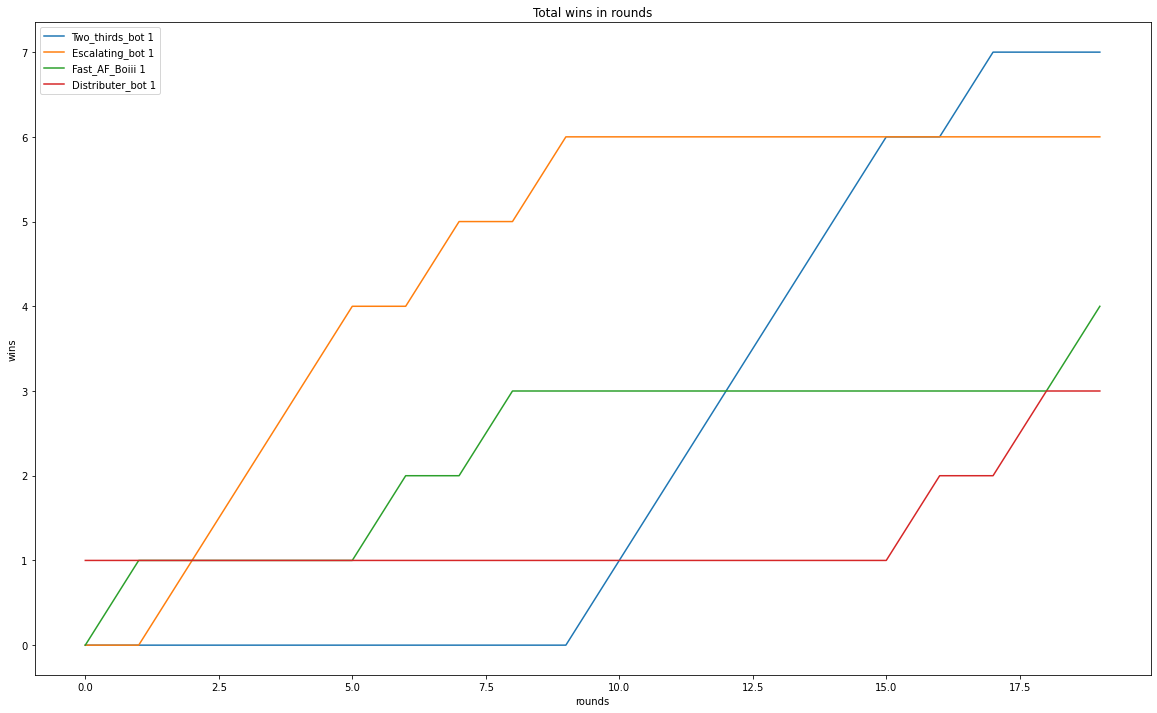

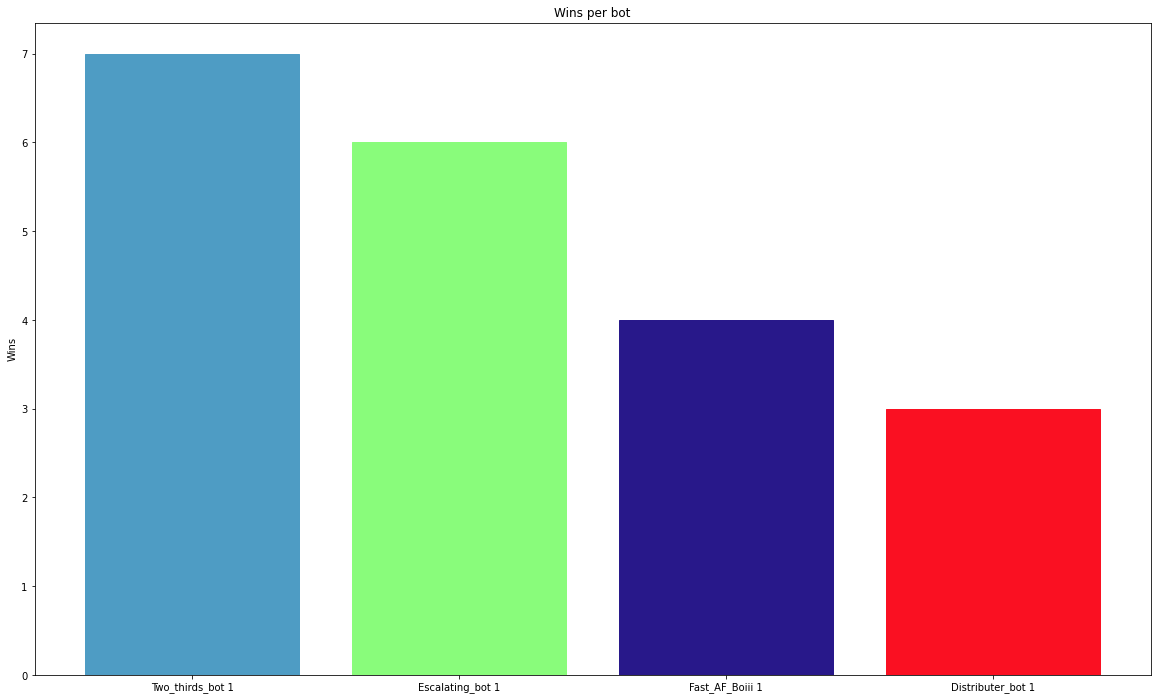

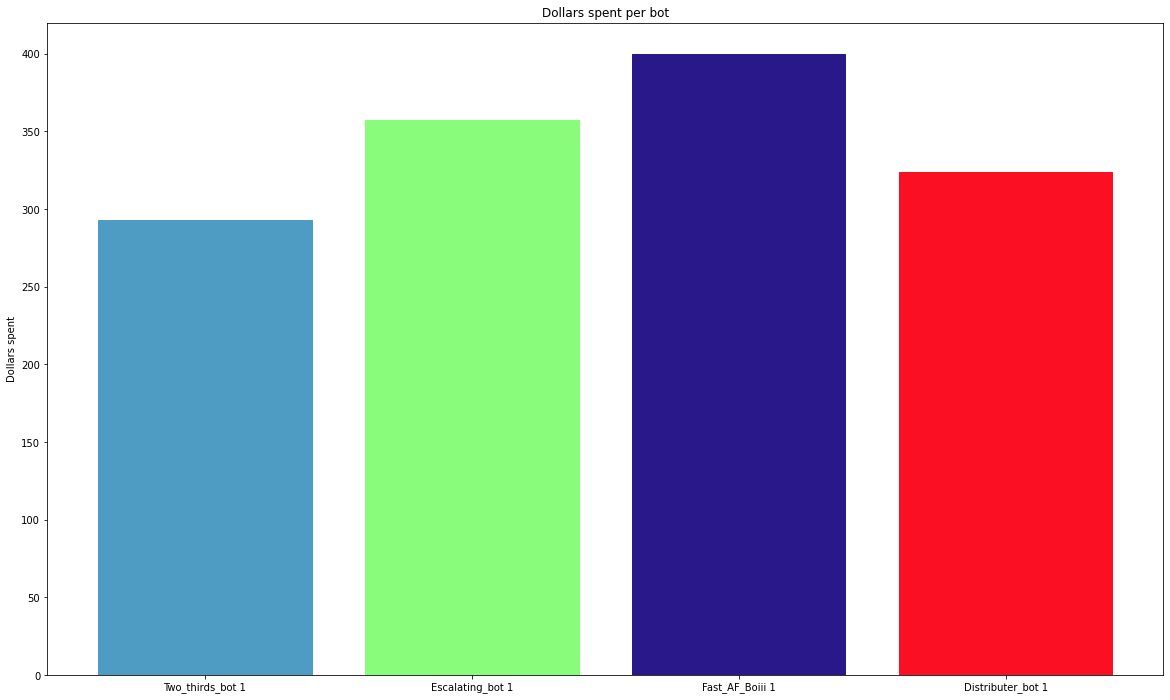

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 0) 


display(bots_names)
infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 4.2

Bots:

1.   ***Distributer_bot***
2.   ***Fast_AF_Boiii***
3.   ***Escalating_bot***
4.   ***Two_thirds_bot***

Scenario:

*   Protocol: ***First Price***
*   Rounds: ***20***
*   Round payment: ***50***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Escalating_bot(budget=budget))
    bot_list.append(Fast_AF_Boiii(budget=budget))
    bot_list.append(Two_thirds_bot(budget=budget))
    bot_list.append(Distributer_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Escalating_bot 1     Score: 9      Total: 1089
Distributer_bot 1    Score: 5      Total: 844
Two_thirds_bot 1     Score: 4      Total: 960
Fast_AF_Boiii 1      Score: 2      Total: 1400


['Two_thirds_bot 1',
 'Escalating_bot 1',
 'Fast_AF_Boiii 1',
 'Distributer_bot 1']

{'Escalating_bot 1': [9, 1089], 'Distributer_bot 1': [5, 844], 'Two_thirds_bot 1': [4, 960], 'Fast_AF_Boiii 1': [2, 1400]}


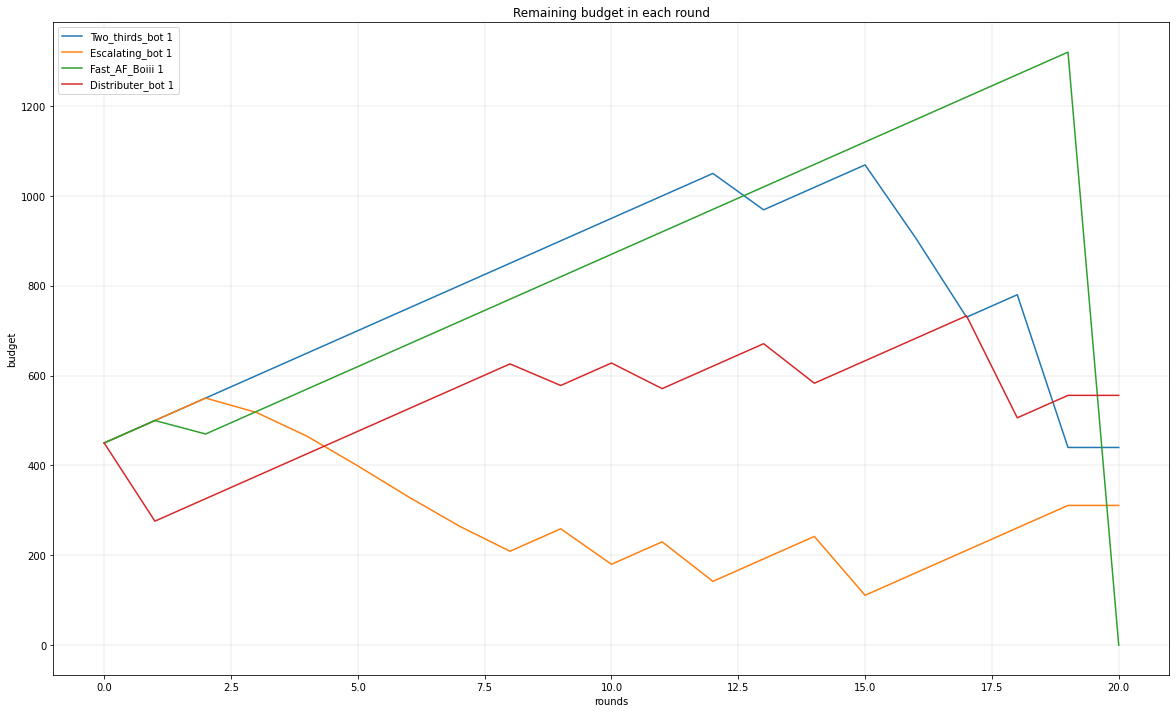

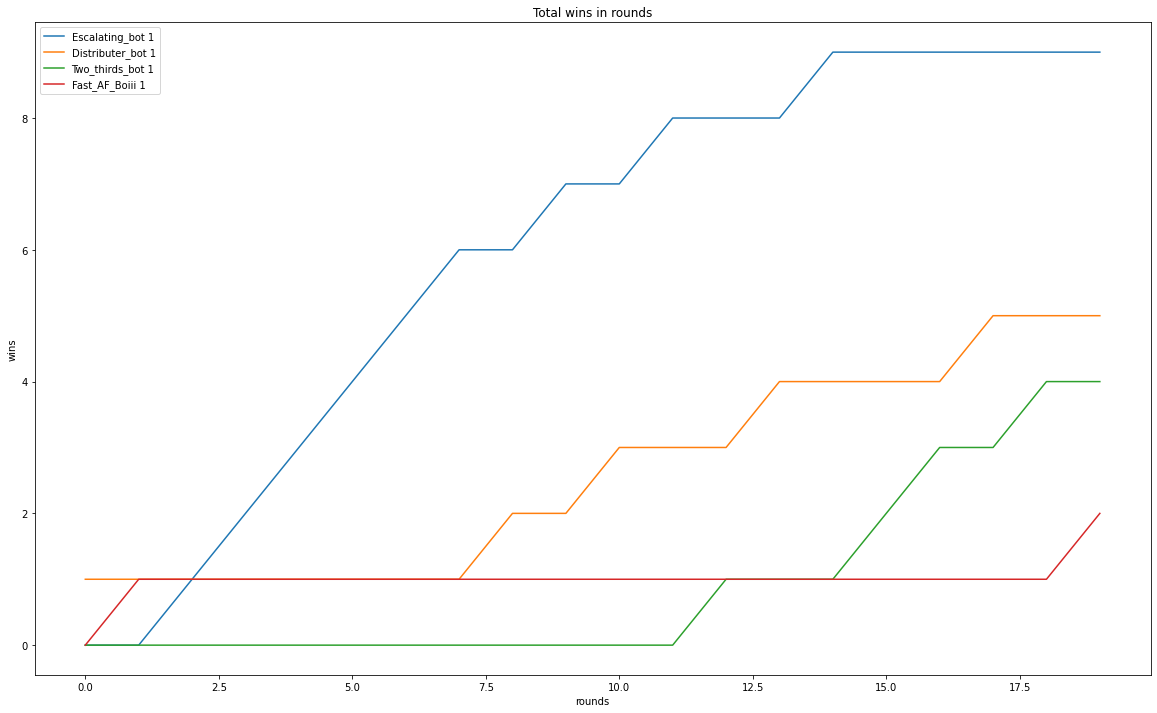

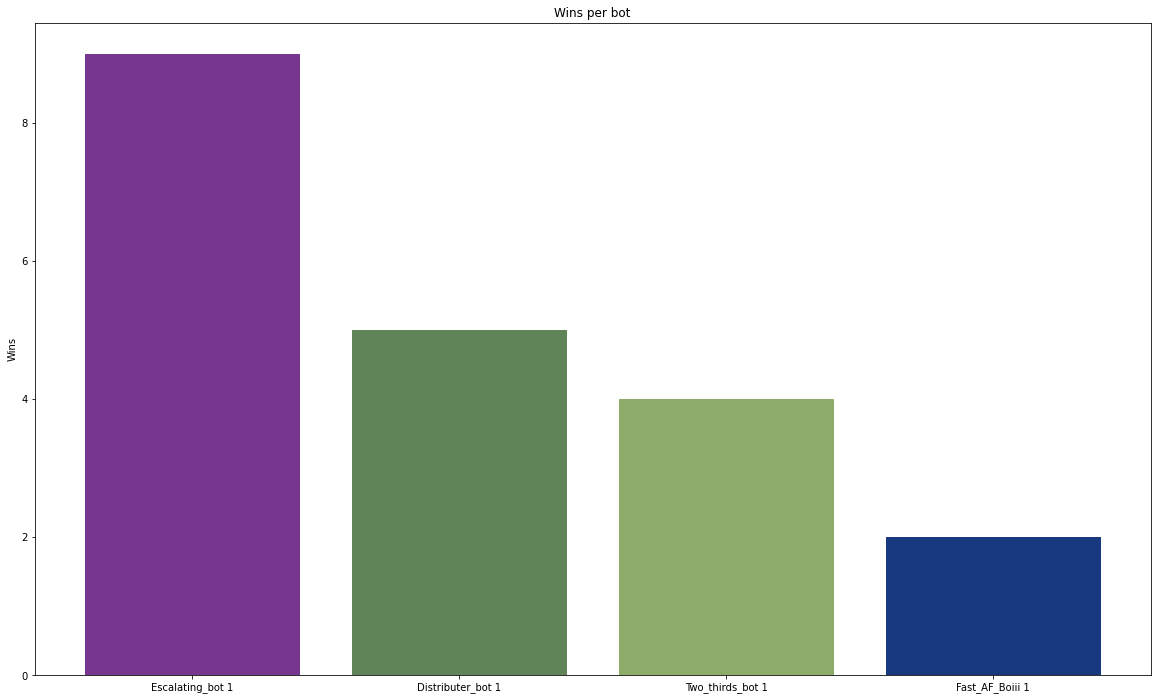

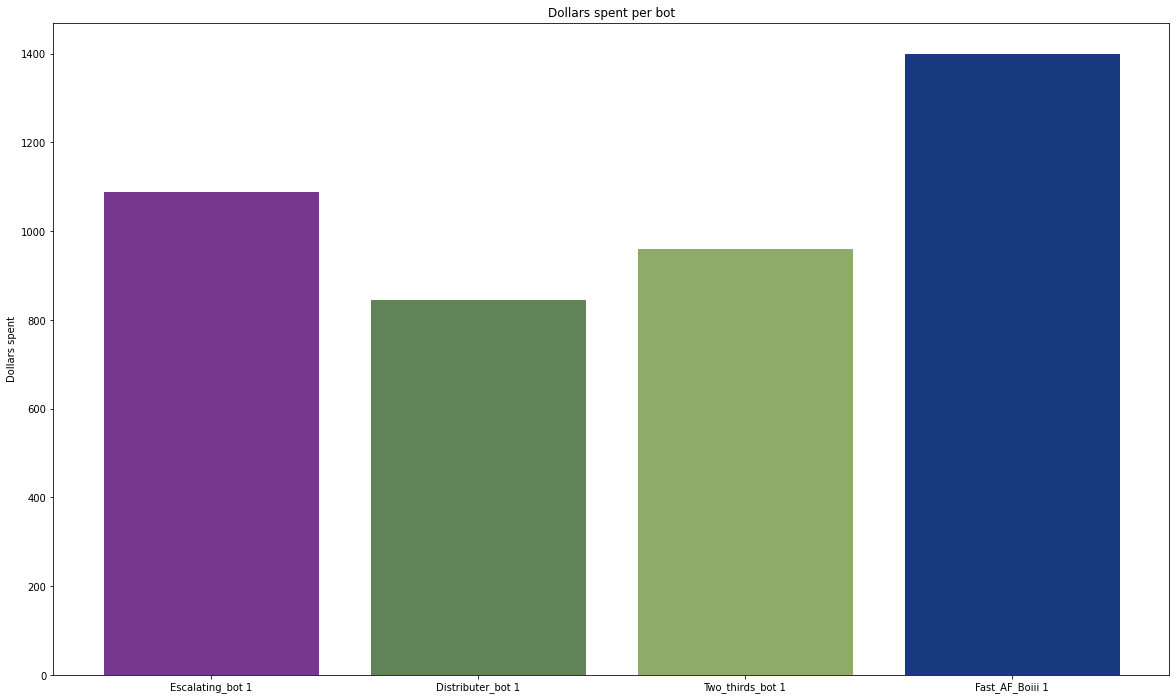

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 50) 


display(bots_names)
infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 5.1

Bots:

1.   ***Minus_one_bot***
2.   ***Half_in_bot***
3.   ***Average_bot***
4.   ***Beat_the_winner_bot***

Scenario:

*   Protocol: ***Second Price***
*   Rounds: ***20***
*   Round payment: ***50***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Minus_one_bot(budget=budget))
    bot_list.append(Half_in_bot(budget=budget))
    bot_list.append(Average_bot(budget=budget))
    bot_list.append(Beat_the_winner_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Minus_one_bot 1      Score: 6      Total: 1274
Beat_the_winner_bot 1 Score: 5      Total: 883
Average_bot 1        Score: 5      Total: 1385
Half_in_bot 1        Score: 4      Total: 842


['Average_bot 1', 'Minus_one_bot 1', 'Half_in_bot 1', 'Beat_the_winner_bot 1']

{'Minus_one_bot 1': [6, 1274], 'Beat_the_winner_bot 1': [5, 883], 'Average_bot 1': [5, 1385], 'Half_in_bot 1': [4, 842]}


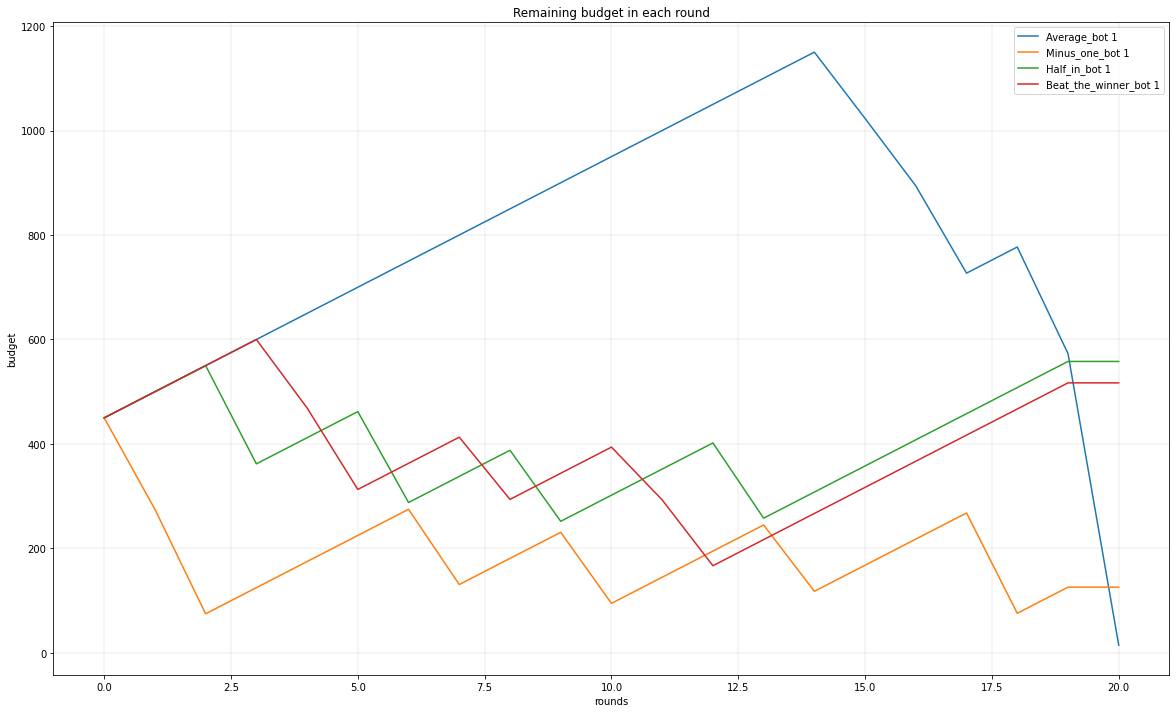

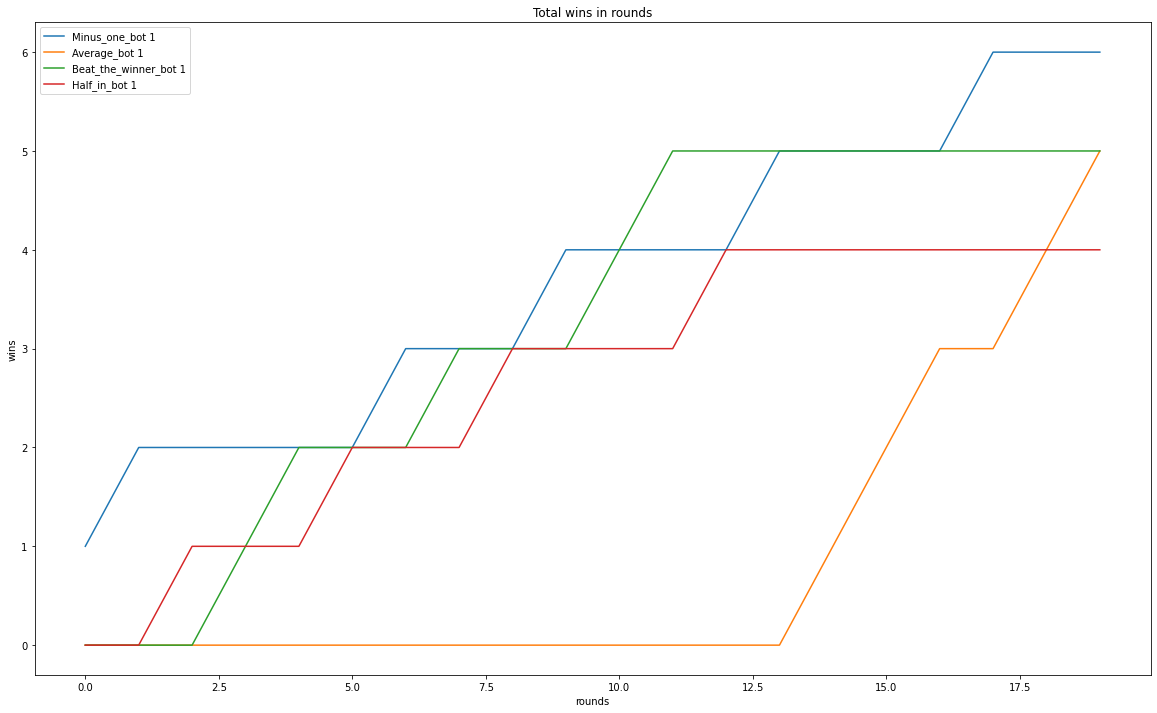

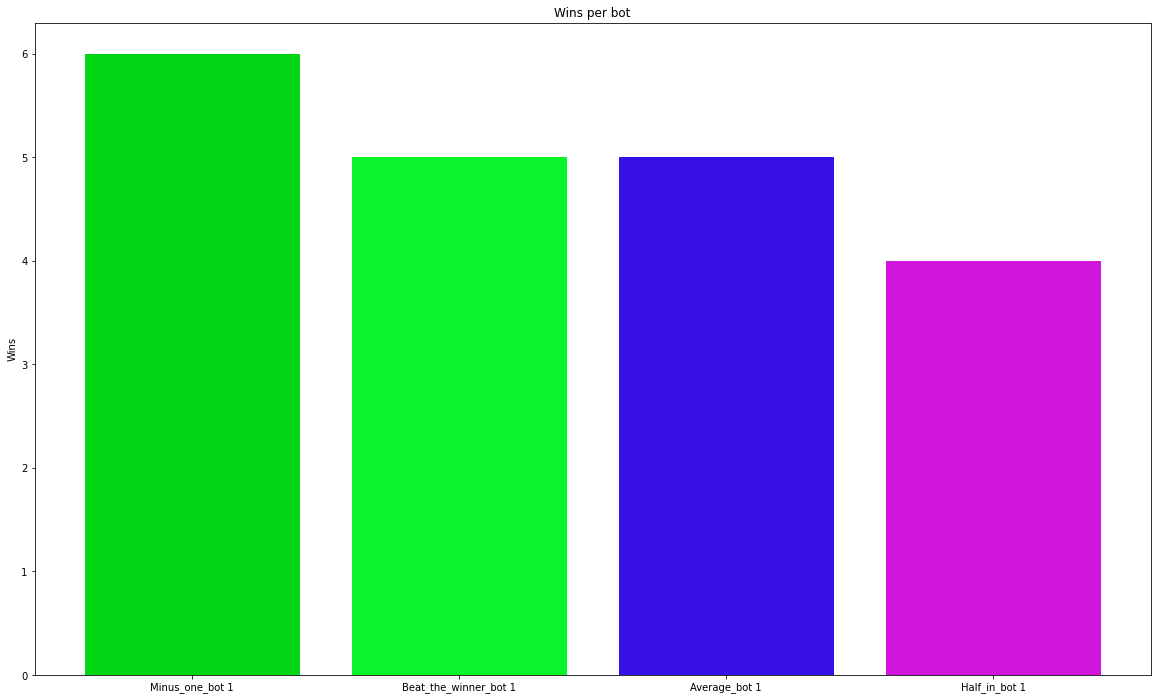

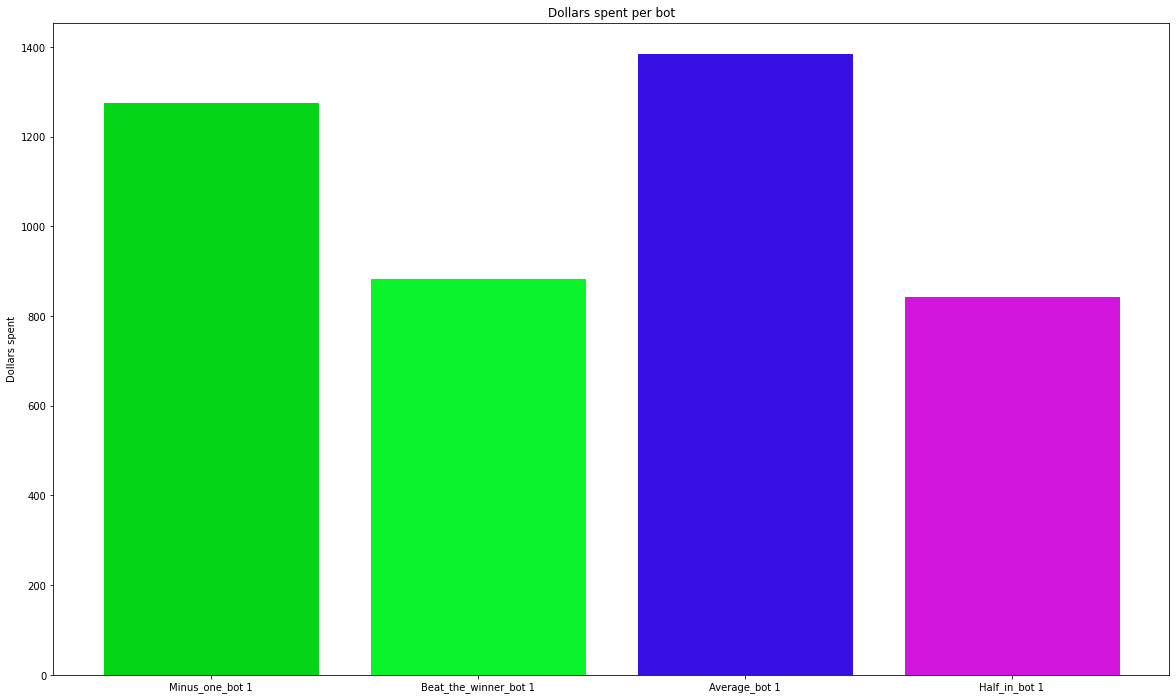

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=0
num_of_second_price_auctions=1

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, 50) 


display(bots_names)
infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)

## Test 5.2

Bots:

1.   ***Minus_one_bot***
2.   ***Half_in_bot***
3.   ***Average_bot***
4.   ***Beat_the_winner_bot***

Scenario:

*   Protocol: ***Second Price***
*   Rounds: ***20***
*   Round payment: ***-5***
*   Budget: ***400***


In [ ]:
# Method that initialises bots and returns a list with them
def init_bots(num_of_rounds):
    # Changing the Class variable for the number of rounds that the average bots
    # and other bots are using
    Bot.set_auction_rounds(num_of_rounds)
    Bot.clear_dict()
    bot_list = []

    # Initialises bots
    budget = 400
    bot_list.append(Minus_one_bot(budget=budget))
    bot_list.append(Half_in_bot(budget=budget))
    bot_list.append(Average_bot(budget=budget))
    bot_list.append(Beat_the_winner_bot(budget=budget))

    return bot_list

In order for the graph be plotted correctly we run only 1 auction at the time

Average_bot 1        Score: 15     Total: 300
Half_in_bot 1        Score: 3      Total: 330
Beat_the_winner_bot 1 Score: 1      Total: 390
Minus_one_bot 1      Score: 1      Total: 394


['Average_bot 1', 'Minus_one_bot 1', 'Half_in_bot 1', 'Beat_the_winner_bot 1']

{'Average_bot 1': [15, 300], 'Half_in_bot 1': [3, 330], 'Beat_the_winner_bot 1': [1, 390], 'Minus_one_bot 1': [1, 394]}


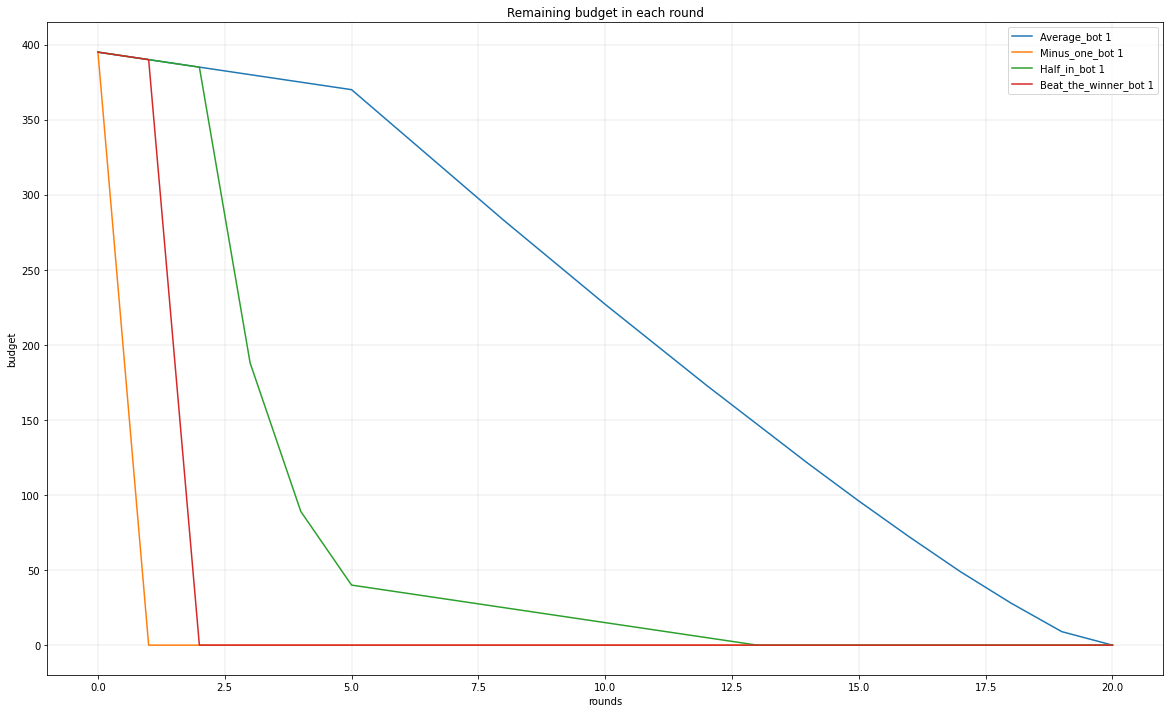

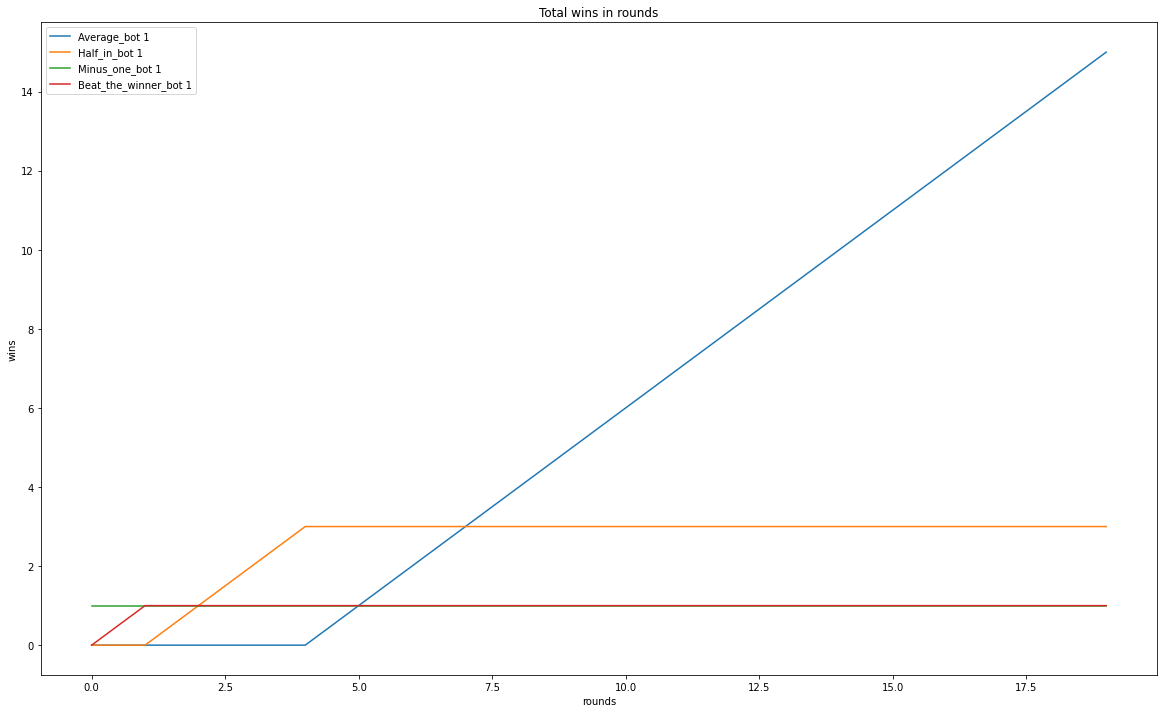

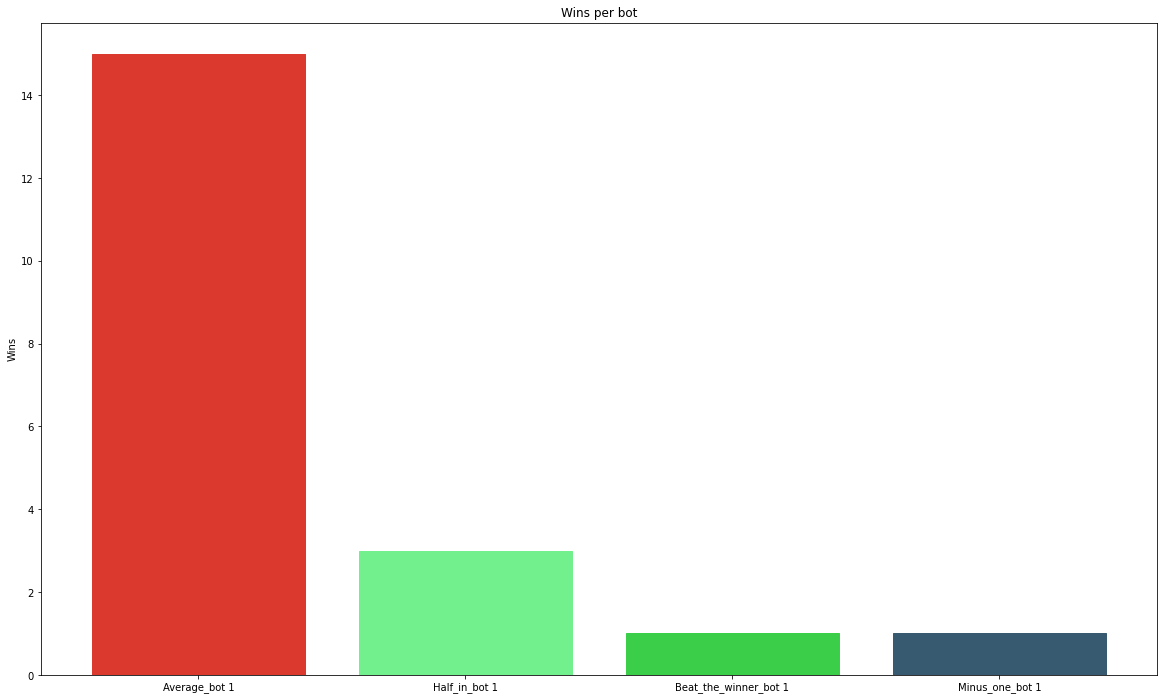

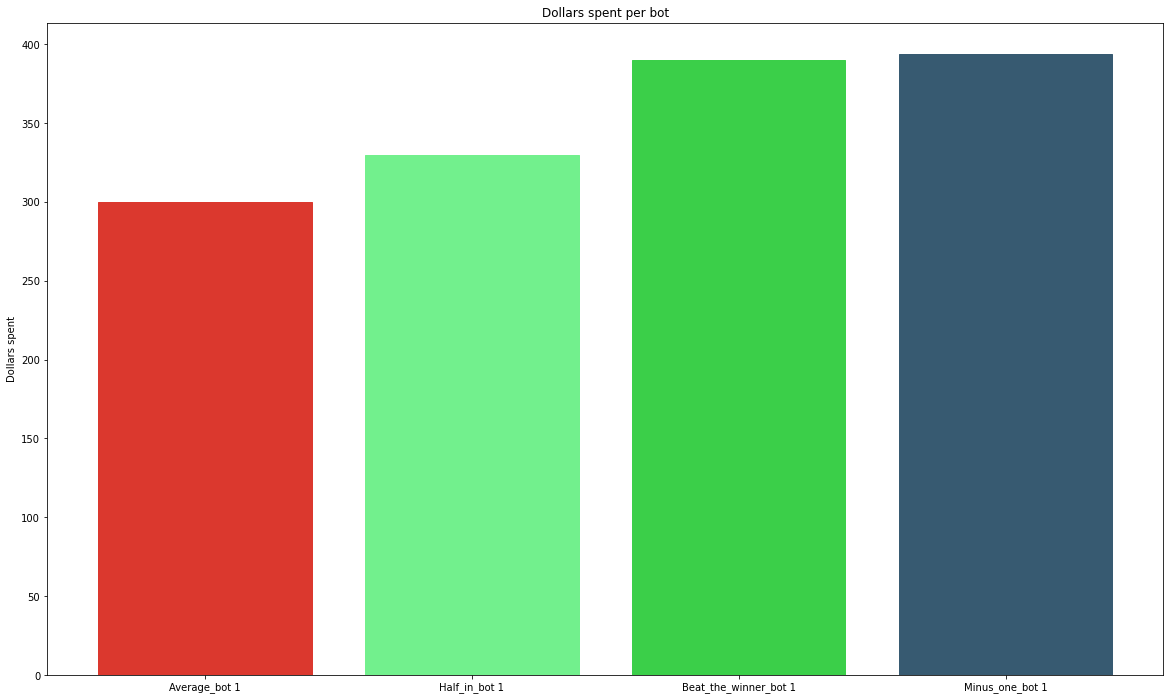

In [ ]:
num_of_rounds=20

num_of_first_price_auctions=1
num_of_second_price_auctions=0

type_of_auctions = []

for i in range (num_of_first_price_auctions):
  type_of_auctions.append("first_price")

for i in range (num_of_second_price_auctions):
  type_of_auctions.append("second_price")

data_plot = [] 
bots_names = [] 
winner_data_plot = [] 
money_spent, infos = run_auctions(type_of_auctions, num_of_rounds, -5) 
display(bots_names)

infos = dict(sorted(infos.items(), key = lambda item : (-item[1][0], item[1][1])))

print(infos)

graph = Graphs(len(bots_names))
graph.loss_of_budget_plot(num_of_rounds)
graph.wins_plot()
graph.winner_bar_graph(infos)
graph.money_spent_bar_graph(infos)